<a href="https://colab.research.google.com/github/yuvalten1/Estimation-of-Yield-and-Loss-in-Pomegranate-Orchards-Using-Deep-Learning-and-Tracking/blob/main/estimation_pomegranate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#connect to drive for data storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Install dependencies

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:

!pip install ultralytics
!pip install torch torchvision torchaudio
%pip install "supervision==0.25.0"
%pip install "trackers==2.0.1" --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.8 MB/s eta 0:00:00


# Download dataset from Roboflow Universe

In [ ]:
!pip install roboflow


In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="iDAVu5fIQ8b91PndHcMI")
project = rf.workspace("image-proccesing-gsjxv").project("tzora_pomogranate_cropped")
version = project.version(22)
dataset = version.download("yolov9")


In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

Install packages

In [ ]:
!pip install albumentations
!pip install opencv-python-headless


In [ ]:
import os
import cv2
import albumentations as A
from glob import glob


# Dataset arangement for creating 3 datasets: yield & loss dataset, yield dataset and loss dataset

**Rename the version of images for future dataset versions**

In [ ]:
import os

# Define the old and new folder names
old_folder_path = "/content/tzora_pomogranate_cropped-22"  # Change this to your actual folder path
new_folder_path = "/content/tzora_pomogranate_cropped"  # Change this to the new name

# Check if the old folder exists
if os.path.exists(old_folder_path):
    os.rename(old_folder_path, new_folder_path)
    print(f"Renamed '{old_folder_path}' to '{new_folder_path}' successfully!")
else:
    print(f"Folder '{old_folder_path}' not found.")

**Duplicate dataset for 2 models training**

In [ ]:
import shutil
import os

def duplicate_directory(src_path):
    if not os.path.exists(src_path):
        print(f"Source path '{src_path}' does not exist.")
        return

    base_dir = os.path.dirname(src_path)
    dir_name = os.path.basename(src_path)

    defected_path = os.path.join(base_dir, f"{dir_name}_defected")
    yield_path = os.path.join(base_dir, f"{dir_name}_yield")

    # Copying the directory
    shutil.copytree(src_path, defected_path)
    shutil.copytree(src_path, yield_path)

    print(f"Duplicated '{src_path}' to '{defected_path}' and '{yield_path}'")

# Example usage
source_path = "/content/tzora_pomogranate_cropped"
duplicate_directory(source_path)


In [ ]:
def clean_labels(path):
    if path.endswith("_defected"):
        class_to_remove = "1"
    elif path.endswith("_yield"):
        class_to_remove = "0"
    else:
        print("Invalid path suffix.")
        return

    for dataset in ["test", "train", "valid"]:
        labels_path = os.path.join(path, dataset, "labels")
        if os.path.exists(labels_path):
            for file in os.listdir(labels_path):
                file_path = os.path.join(labels_path, file)
                with open(file_path, "r") as f:
                    lines = f.readlines()

                with open(file_path, "w") as f:
                    for line in lines:
                        if not line.startswith(class_to_remove + " "):
                            f.write(line)

    print(f"Removed annotations of class {class_to_remove} from labels in '{path}'")

# Example usage
defected_path = "/content/tzora_pomogranate_cropped_defected"
yield_path = "/content/tzora_pomogranate_cropped_yield"
clean_labels(defected_path)
clean_labels(yield_path)

In [ ]:
import glob
###convert yield lables into zero
def convert_labels_to_zero(label_file):
    """Reads a label file and converts all class indices to 0."""
    with open(label_file, "r") as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if parts:  # Ensure the line is not empty
            parts[0] = "0"  # Set class index to 0
            new_lines.append(" ".join(parts))

    with open(label_file, "w") as f:
        f.write("\n".join(new_lines))

def process_all_labels(label_dir):
    """Processes all label files in the specified directory."""
    label_files = glob.glob(f"{label_dir}/*.txt")
    for file in label_files:
        convert_labels_to_zero(file)

# Example usage:
process_all_labels("/content/tzora_pomogranate_cropped_yield/train/labels")
process_all_labels("/content/tzora_pomogranate_cropped_yield/valid/labels")
process_all_labels("/content/tzora_pomogranate_cropped_yield/test/labels")


In [ ]:
import yaml

def update_yaml(path, class_names):
    yaml_path = os.path.join(path, "data.yaml")
    if os.path.exists(yaml_path):
        with open(yaml_path, "r") as f:
            data = yaml.safe_load(f)

        data["names"] = list(class_names)  # Ensure correct YAML formatting
        data["nc"] = 1

        with open(yaml_path, "w") as f:
            yaml.dump(data, f, default_flow_style=False, sort_keys=False, width=1000, allow_unicode=True)

        print(f"Updated 'data.yaml' in '{path}' with class names: {class_names}")


# Example usage
update_yaml(yield_path, ["pomegranates"])

update_yaml(defected_path, ["defected"])

Updated 'data.yaml' in '/content/tzora_pomogranate_cropped_yield' with class names: ['pomegranates']
Updated 'data.yaml' in '/content/tzora_pomogranate_cropped_defected' with class names: ['defected']


#Adding images to the orchard training set for teaching the model the presence of red tape

In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="iDAVu5fIQ8b91PndHcMI")
project = rf.workspace("image-proccesing-gsjxv").project("pomegranate-loss-fine-tuning-dbrbg")
version = project.version(1)
dataset = version.download("yolov9")


In [ ]:
import os
import shutil

def copy_folder_contents(src_dir, dst_dir):
    """
    Copies all files and subfolders from src_dir into dst_dir.
    - Creates dst_dir if it doesn’t exist.
    - Does NOT overwrite files that already exist in dst_dir.
    """
    if not os.path.exists(src_dir):
        raise FileNotFoundError(f"Source directory not found: {src_dir}")

    os.makedirs(dst_dir, exist_ok=True)

    for root, dirs, files in os.walk(src_dir):
        # Preserve folder structure relative to the source
        rel_path = os.path.relpath(root, src_dir)
        target_root = os.path.join(dst_dir, rel_path)
        os.makedirs(target_root, exist_ok=True)

        for file in files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(target_root, file)

            # Only copy if the file does NOT exist
            if not os.path.exists(dst_file):
                shutil.copy2(src_file, dst_file)
                print(f" Copied: {src_file} → {dst_file}")
            else:
                print(f" Skipped (already exists): {dst_file}")

    print(f"\n Finished copying (existing files were skipped).")

# ===== Example usage =====
fine_tune_images = "/content/pomegranate-loss-fine-tuning-1/train/images"
training_images = "/content/tzora_pomogranate_cropped_defected/train/images"
copy_folder_contents(fine_tune_images, training_images)

fine_tune_lables = "/content/pomegranate-loss-fine-tuning-1/train/labels"
training_lables = "/content/tzora_pomogranate_cropped_defected/train/lables"
copy_folder_contents(fine_tune_lables, fine_tune_lables)

# Preform pre-processing**


In [ ]:
import os
import cv2
import numpy as np

def apply_clahe(image):
    """Apply CLAHE to an image to enhance local contrast."""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

def enhance_saturation(image, saturation_scale=1.3):
    """Enhance the saturation of an image."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    s = np.clip(s * saturation_scale, 0, 255).astype(np.uint8)
    enhanced_image = cv2.merge([h, s, v])
    return cv2.cvtColor(enhanced_image, cv2.COLOR_HSV2RGB)

def process_images(image_dir):
    """Process images in a directory with CLAHE and saturation enhancement, then overwrite them."""
    # Loop through all images in the directory
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            if image is not None:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Apply CLAHE and then enhance saturation
                clahe_image = apply_clahe(image_rgb)
                final_image = enhance_saturation(clahe_image)

                final_image_bgr = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)

                # Overwrite and save the original image
                cv2.imwrite(image_path, final_image_bgr)
                print(f"Processed and overwrote {filename}")
            else:
                print(f"Failed to load {filename}")
        else:
            print(f"Skipped {filename}, not an image file")


In [ ]:
yield_train_images_path= '/content/tzora_pomogranate_cropped_yield/train/images'
defected_train_images_path= '/content/tzora_pomogranate_cropped_defected/train/images'
both_train_images_path= '/content/tzora_pomogranate_cropped/train/images'
process_images(defected_train_images_path)
process_images(yield_train_images_path)
process_images(both_train_images_path)

In [ ]:
#yield valid and test preprocess
yield_valid_images_path= '/content/tzora_pomogranate_cropped_yield/valid/images'
process_images(yield_valid_images_path)
yield_test_images_path= '/content/tzora_pomogranate_cropped_yield/test/images'
process_images(yield_test_images_path)

#defected valid and test preprocess
defected_valid_images_path= '/content/tzora_pomogranate_cropped_defected/valid/images'
process_images(defected_valid_images_path)
defected_test_images_path= '/content/tzora_pomogranate_cropped_defected/test/images'
process_images(defected_test_images_path)

In [ ]:
#defected valid and test preprocess
both_valid_images_path= '/content/tzora_pomogranate_cropped/valid/images'
process_images(both_valid_images_path)
both_test_images_path= '/content/tzora_pomogranate_cropped/test/images'
process_images(both_test_images_path)

In [ ]:
#adding Transformations, Noise Addition and Blurring

augmentation_pipeline = A.Compose([
    A.OneOf([
        A.GaussNoise(std_range =([0.1, 0.1]),per_channel=True),
       A.Blur(blur_limit=(3, 5))  # Random kernel size: 3 or 5,
    ], p=1),
])

In [ ]:
import os
import cv2
from glob import glob
import random
import glob

#functions for augumenting and saving the augumantations

# Function to Read and Write Label Files:
def read_label_file(label_path):
    with open(label_path, 'r') as file:
        return file.readlines()

def write_label_file(label_path, content):
    with open(label_path, 'w') as file:
        file.writelines(content)

def save_image_and_label(image, filename, suffix, image_dir, label_dir):
    # paths for augmented image and label
    aug_image_path = os.path.join(image_dir, filename.replace('.jpg', f'_{suffix}.jpg'))
    aug_label_path = os.path.join(label_dir, filename.replace('.jpg', f'_{suffix}.txt'))

    # Ensure the directory exists
    os.makedirs(os.path.dirname(aug_image_path), exist_ok=True)
    os.makedirs(os.path.dirname(aug_label_path), exist_ok=True)

    # Save augmented image
    cv2.imwrite(aug_image_path, image)

    # Save label if exists
    label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt'))
    if os.path.exists(label_path):
        label_content = read_label_file(label_path)
        write_label_file(aug_label_path, label_content)
    else:
        print(f"Label not found for image {filename}")

#augment_and_save images before trainig
def augment_and_save(image_dir, label_dir, num_augmentations=1):
    for image_path in glob.glob(os.path.join(image_dir, '*.jpg')): # Changed glob to glob.glob
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        filename = os.path.basename(image_path)

        for i in range(num_augmentations):
            # Set a unique seed for each iteration
            seed = random.randint(0, 100000)
            random.seed(seed)
            np.random.seed(seed)

            # Apply the pipeline
            augmented = augmentation_pipeline(image=image)['image']

            # Convert RGB back to BGR before saving
            augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)

            # Save with a unique suffix
            save_image_and_label(augmented_bgr, filename, f'augmented_{i+1}', image_dir, label_dir)

    print(f"Augmentation and saving completed ({num_augmentations}x per image).")





In [ ]:
yield_train_images_path= '/content/tzora_pomogranate_cropped_yield/train/images'
defected_train_images_path= '/content/tzora_pomogranate_cropped_defected/train/images'
bothg_train_images_path= '/content/tzora_pomogranate_cropped/train/images'

yield_train_lables_path= '/content/tzora_pomogranate_cropped_yield/train/labels'
defected_train_lables_path= '/content/tzora_pomogranate_cropped_defected/train/labels'
both_train_lables_path= '/content/tzora_pomogranate_cropped/train/labels'

augment_and_save(yield_train_images_path, yield_train_lables_path)
augment_and_save(defected_train_images_path, defected_train_lables_path)
augment_and_save(bothg_train_images_path, both_train_lables_path)

In [ ]:
#check number of images in the training set
import glob # Import the glob module

image_files = glob.glob(os.path.join(yield_train_images_path, '*.jpg'))
print(f"Number of original + augmented images: {len(image_files)}")


Number of original + augmented images: 852


#fine_tune

In [ ]:
from ultralytics import YOLO

# ===== 1. Load your existing model =====
model_path = "/content/drive/MyDrive/thesis_notebook_files/model_defected_yolo11s_100_epochs_v21_agumentation_fixed_not_doubled/weights/best.pt"
model_fine_tune = YOLO(model_path)

# ===== 2. Path to your dataset YAML =====
data_yaml = "/content/tzora_pomogranate_cropped_defected/data.yaml"  # <- change to your dataset yaml path

# ===== 3. Train (fine-tune) =====
model_fine_tune.train(
    data=data_yaml,        # dataset definition (train/val paths)
    epochs=10,             # few epochs for fine-tuning
    imgsz=1280,            # image size (same as before)
    batch=8,               # adjust to your GPU memory
    lr0=5e-4,              # smaller LR for gentle fine-tune
    lrf=0.1,
    freeze=10,             # freeze early backbone layers
    cos_lr=True,           # cosine learning schedule
    mosaic=0.1,            # minimal augmentations for stability
    mixup=0.0,
    copy_paste=0.0,
    hsv_h=0.015,
    hsv_s=0.4,
    hsv_v=0.4,
    fliplr=0.5,
    translate=0.05,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    project="runs/detect",   # output folder (default)
    name="fine_tune_defected_v21",  # experiment name
)

print("✅ Fine-tuning started successfully!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/tzora_pomogranate_cropped_defected/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=1280, int8=F

#Tiling

In [ ]:
#duplicate /content/tzora_pomogranate_cropped and call it /content/tzora_pomogranate_cropped_tiles

import shutil
import os

# Define source and destination paths
source_path = "/content/tzora_pomogranate_cropped"
destination_path = "/content/tzora_pomogranate_cropped_tiles"

def duplicate_directory(source_path,destination_path):
  # Check if the source directory exists
  if os.path.exists(source_path):
      try:
          # Copy the directory
          shutil.copytree(source_path, destination_path)
          print(f"Successfully duplicated '{source_path}' to '{destination_path}'")
      except FileExistsError:
          print(f"Destination directory '{destination_path}' already exists.")
      except OSError as e:
          print(f"Error duplicating directory: {e}")
  else:
      print(f"Source directory '{source_path}' not found.")


In [ ]:
import os
import cv2
import shutil
import numpy as np

def split_image_and_labels(image_path, label_path, grid_size, overlap, output_image_dir, output_label_dir):
    image = cv2.imread(image_path)
    if image is None:
        print(f"unreadable {image_path}")
        return

    h, w, _ = image.shape
    grid_x, grid_y = grid_size
    tile_w = int(w / grid_x)
    tile_h = int(h / grid_y)

    overlap_x = int(tile_w * overlap)
    overlap_y = int(tile_h * overlap)

    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            labels = [line.strip().split() for line in f.readlines()]

    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    tile_count = 0
    for row in range(grid_y):
        for col in range(grid_x):
            x = max(col * tile_w - col * overlap_x, 0)
            y = max(row * tile_h - row * overlap_y, 0)
            x_end = min(x + tile_w, w)
            y_end = min(y + tile_h, h)

            tile = image[y:y_end, x:x_end]

            tile_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_{tile_count}.jpg"
            tile_path = os.path.join(output_image_dir, tile_filename)
            cv2.imwrite(tile_path, tile)

            new_labels = []
            for label in labels:
                cls, x_center, y_center, bbox_w, bbox_h = map(float, label)

                orig_x = x_center * w
                orig_y = y_center * h
                orig_w = bbox_w * w
                orig_h = bbox_h * h

                if (x <= orig_x <= x_end) and (y <= orig_y <= y_end):
                    new_x = (orig_x - x) / (x_end - x)
                    new_y = (orig_y - y) / (y_end - y)
                    new_w = orig_w / (x_end - x)
                    new_h = orig_h / (y_end - y)
                    new_labels.append(f"{int(cls)} {new_x:.6f} {new_y:.6f} {new_w:.6f} {new_h:.6f}")

            if new_labels:
                label_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_{tile_count}.txt"
                label_path = os.path.join(output_label_dir, label_filename)
                with open(label_path, "w") as f:
                    f.write("\n".join(new_labels))

            tile_count += 1
def tile_datasets(split_dir, output_dir, grid_size=(2, 2), overlap=0.1):
    image_dir = os.path.join(split_dir, "images")
    label_dir = os.path.join(split_dir, "labels")
    output_image_dir = os.path.join(output_dir, "images")
    output_label_dir = os.path.join(output_dir, "labels")

    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for image_file in os.listdir(image_dir):
        if image_file.endswith((".jpg", ".png")):
            image_path = os.path.join(image_dir, image_file)
            label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + ".txt")

            split_image_and_labels(
                image_path,
                label_path,
                grid_size=grid_size,
                overlap=overlap,
                output_image_dir=output_image_dir,
                output_label_dir=output_label_dir
            )
            print(f"Processed {image_file}")

    shutil.rmtree(split_dir)
    os.rename(output_dir, split_dir)


create defected_tiles_dataset

In [ ]:
#create tiled defected dataset
source_path = "/content/tzora_pomogranate_cropped_defected"
destination_path = "/content/tzora_pomogranate_cropped_defected_tiles"
duplicate_directory(source_path,destination_path)

Successfully duplicated '/content/tzora_pomogranate_cropped_defected' to '/content/tzora_pomogranate_cropped_defected_tiles'


In [ ]:
#tile all datasets
tile_datasets("/content/tzora_pomogranate_cropped_defected_tiles/train", "/content/tzora_pomogranate_cropped_defected_tiles/train_tiles")
tile_datasets("/content/tzora_pomogranate_cropped_defected_tiles/test", "/content/tzora_pomogranate_cropped_defected_tiles/test_tiles")
tile_datasets("/content/tzora_pomogranate_cropped_defected_tiles/valid", "/content/tzora_pomogranate_cropped_defected_tiles/valid_tiles")

In [ ]:
#counting number of images after tiling
import os

image_dir_tiles = "/content/tzora_pomogranate_cropped_defected_tiles/train/images"
reg_image_dir = "/content/tzora_pomogranate_cropped_defected/train/images"
image_count_tiles = len([f for f in os.listdir(image_dir_tiles) if os.path.isfile(os.path.join(image_dir_tiles, f))])
image_count_reg = len([f for f in os.listdir(reg_image_dir) if os.path.isfile(os.path.join(reg_image_dir, f))])

print(f"There are {image_count_tiles} images in {image_dir_tiles}")
print(f'There are {image_count_reg} images in "/content/tzora_pomogranate_cropped_defected/train/images"')


There are 1704 images in /content/tzora_pomogranate_cropped_defected_tiles/train/images
There are 426 images in "/content/tzora_pomogranate_cropped_defected/train/images"


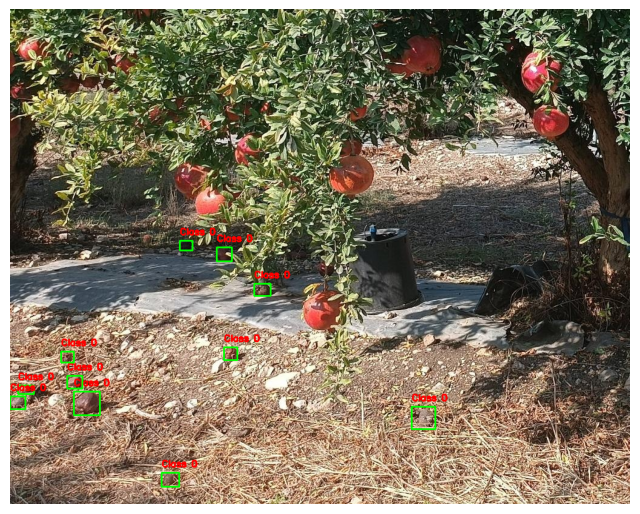

In [ ]:
import matplotlib.pyplot as plt
#saniti check- visualise loss instances on tiled image
def visualize_labels(image_path, label_path):
    """ Visualizes YOLO labels on an image (compatible with Google Colab)."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Cannot read image: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            labels = [line.strip().split() for line in f.readlines()]

        for label in labels:
            cls, x_center, y_center, bbox_w, bbox_h = map(float, label)
            x1 = int((x_center - bbox_w / 2) * w)
            y1 = int((y_center - bbox_h / 2) * h)
            x2 = int((x_center + bbox_w / 2) * w)
            y2 = int((y_center + bbox_h / 2) * h)

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"Class {int(cls)}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display image inline in Colab
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")  # Hide axis
    plt.show()

visualize_labels('/content/tzora_pomogranate_cropped_defected_tiles/test/images/BE3_1_s_jpg.rf.22375de43d341022eae767d46a5b4a42_2.jpg', '/content/tzora_pomogranate_cropped_defected_tiles/test/labels/BE3_1_s_jpg.rf.22375de43d341022eae767d46a5b4a42_2.txt')


In [ ]:
# נתיב לתיקייה שבה נשמרו התוצאות
import shutil
import os

# Assuming you want to copy the entire 'train' directory
results_path = "/content/runs/detect/train3" # Corrected path to the directory

# נתיב לתיקייה בדרייב
drive_path = "/content/drive/MyDrive/thesis_notebook_files/yolov10s_both_from_scratch_yolov10_100_epohcs_6_1"
# העתקת התוצאות
# Ensure the source directory exists before attempting to copy
if os.path.isdir(results_path):
    shutil.copytree(results_path, drive_path, dirs_exist_ok=True)
    print(f"Results copied from {results_path} to {drive_path}")
else:
    print(f"Error: Source directory not found at {results_path}")

# training models

In [ ]:
from ultralytics import YOLO
model_tiled_defected = YOLO("yolov10s.pt")

yaml_file = '/content/tzora_pomogranate_cropped_defected_tiles/data.yaml'

# # Train the model
# Train the model using the tuned parameters
model_tiled_defected.train(data=yaml_file,
            epochs=100,
            # optimizer='AdamW',
            # **valid_params,
            plots=True,
            save=True,
            single_cls=True
            )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/tzora_pomogranate_cropped_defected_tiles/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False,

100%|██████████| 755k/755k [00:00<00:00, 96.8MB/s]

Overriding class names with single class.
Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7    

 23        [16, 19, 22]  1   1639574  ultralytics.nn.modules.head.v10Detect        [1, [128, 256, 512]]          
YOLOv10s summary: 234 layers, 8,067,126 parameters, 8,067,110 gradients, 24.8 GFLOPs

Transferred 607/619 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 400MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2609.8±559.9 MB/s, size: 445.3 KB)


train: Scanning /content/tzora_pomogranate_cropped_defected_tiles/train/labels... 2224 images, 1184 backgrounds, 0 corrupt: 100%|██████████| 3408/3408 [00:01<00:00, 2497.28it/s]

train: New cache created: /content/tzora_pomogranate_cropped_defected_tiles/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 986.8±1079.9 MB/s, size: 699.9 KB)


val: Scanning /content/tzora_pomogranate_cropped_defected_tiles/valid/labels... 79 images, 45 backgrounds, 0 corrupt: 100%|██████████| 124/124 [00:00<00:00, 1322.58it/s]

val: New cache created: /content/tzora_pomogranate_cropped_defected_tiles/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 111 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.25G      4.036      7.364      2.134        143        640: 100%|██████████| 213/213 [01:51<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        124        726      0.556      0.474      0.467      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.32G      3.942      3.392       2.08         80        640: 100%|██████████| 213/213 [01:53<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        124        726      0.646      0.555       0.59      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.37G      3.937      3.382      2.069         92        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        124        726      0.627      0.466      0.503      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.41G      3.873       3.24      2.044        169        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        124        726      0.652       0.55      0.598       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.46G      3.807      3.178      2.037        135        640: 100%|██████████| 213/213 [01:40<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        124        726      0.631      0.534      0.576      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       6.5G      3.756      3.065      2.025        101        640: 100%|██████████| 213/213 [01:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        124        726      0.733       0.55      0.632      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.55G      3.713       2.96      1.999         91        640: 100%|██████████| 213/213 [01:40<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        124        726      0.673      0.594      0.641      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       6.6G      3.683      2.904      1.995        138        640: 100%|██████████| 213/213 [01:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        124        726       0.65      0.577      0.607      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.64G      3.657      2.883      1.997        162        640: 100%|██████████| 213/213 [01:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        124        726      0.741      0.583      0.638      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.69G      3.597      2.801      1.983        138        640: 100%|██████████| 213/213 [01:40<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        124        726      0.648      0.586      0.628      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.73G      3.575      2.667      1.971         69        640: 100%|██████████| 213/213 [01:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        124        726      0.707      0.596      0.662      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.78G      3.557      2.677      1.962        283        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        124        726       0.72      0.596      0.656      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.82G      3.537      2.666      1.959         76        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        124        726       0.74       0.58      0.672      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.87G      3.518      2.595      1.945         75        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        124        726      0.704      0.602      0.657      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.91G      3.515      2.557      1.951        142        640: 100%|██████████| 213/213 [01:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        124        726      0.722      0.597      0.667      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.96G      3.451      2.501      1.944        159        640: 100%|██████████| 213/213 [01:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        124        726      0.708      0.628      0.687      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         7G      3.442      2.452      1.927         81        640: 100%|██████████| 213/213 [01:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        124        726      0.719      0.613       0.68      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.05G      3.453      2.448      1.933         97        640: 100%|██████████| 213/213 [01:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        124        726       0.71      0.584      0.646      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.09G      3.444      2.431      1.927        197        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        124        726      0.753      0.585       0.68      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.14G      3.403      2.338      1.922        248        640: 100%|██████████| 213/213 [01:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        124        726      0.722      0.603      0.675      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.19G      3.388      2.335      1.903        185        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        124        726      0.681      0.611      0.661      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.23G      3.392      2.282      1.916        137        640: 100%|██████████| 213/213 [01:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        124        726      0.758      0.596      0.682      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.28G      3.366      2.249      1.915        233        640: 100%|██████████| 213/213 [01:40<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        124        726      0.753      0.606      0.683      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.32G      3.303      2.183      1.896        107        640: 100%|██████████| 213/213 [01:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        124        726      0.726      0.601       0.66      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.37G      3.311        2.2      1.903        128        640: 100%|██████████| 213/213 [01:42<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        124        726       0.72      0.618      0.672      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.41G      3.308      2.148      1.892        152        640: 100%|██████████| 213/213 [01:40<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        124        726      0.756      0.596      0.668      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.79G      3.315      2.179      1.899         99        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        124        726      0.737      0.611      0.682      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.79G      3.285      2.109      1.893         98        640: 100%|██████████| 213/213 [01:40<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        124        726      0.766      0.601      0.681      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.79G      3.242      2.057      1.883         79        640: 100%|██████████| 213/213 [01:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        124        726      0.728      0.603      0.668      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.79G      3.254       2.05      1.878        108        640: 100%|██████████| 213/213 [01:40<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        124        726      0.712      0.609      0.668      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.79G      3.253      2.054      1.878         79        640: 100%|██████████| 213/213 [01:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        124        726       0.75      0.584       0.67       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.82G      3.215      2.025      1.868        109        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        124        726      0.749      0.591      0.676      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.86G      3.203       1.98       1.87        164        640: 100%|██████████| 213/213 [01:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        124        726      0.772      0.583      0.678      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.91G      3.177       1.96      1.871        195        640: 100%|██████████| 213/213 [01:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        124        726       0.75      0.602      0.675      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.95G      3.181      1.952      1.866        200        640: 100%|██████████| 213/213 [01:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        124        726      0.735      0.615      0.669      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         7G      3.141      1.918      1.857        123        640: 100%|██████████| 213/213 [01:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        124        726        0.7      0.602      0.667      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.04G      3.157      1.914      1.864        220        640: 100%|██████████| 213/213 [01:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        124        726       0.76      0.601      0.673       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.09G      3.099      1.852      1.847        163        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        124        726      0.724      0.611      0.679      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.13G      3.095      1.837      1.847        127        640: 100%|██████████| 213/213 [01:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        124        726      0.764      0.551      0.661      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.18G      3.107      1.851       1.86        191        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        124        726      0.765      0.602      0.686      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.23G      3.065        1.8      1.844        281        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        124        726      0.744      0.588      0.665      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.27G      3.084      1.812      1.848        198        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        124        726      0.725      0.616      0.682      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.32G      3.062      1.773      1.834        125        640: 100%|██████████| 213/213 [01:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        124        726      0.729      0.594      0.668      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.36G      3.078      1.794      1.843        212        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        124        726      0.711      0.588      0.664      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.41G      3.021      1.744      1.838        107        640: 100%|██████████| 213/213 [01:40<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        124        726      0.722      0.586      0.672      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.34G      3.009      1.703      1.827        138        640: 100%|██████████| 213/213 [01:38<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

                   all        124        726      0.753      0.561      0.666      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.34G       2.98      1.692      1.828         91        640: 100%|██████████| 213/213 [01:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        124        726      0.731      0.612      0.677      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.34G       2.99      1.702      1.831        123        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        124        726      0.749      0.569      0.659      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.34G      2.998       1.68      1.826         86        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        124        726      0.757      0.571      0.676      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.36G      2.929      1.634      1.821        128        640: 100%|██████████| 213/213 [01:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        124        726      0.767      0.592      0.679      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       5.4G      2.939      1.624      1.807         89        640: 100%|██████████| 213/213 [01:40<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        124        726      0.747      0.592      0.682      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.45G      2.892      1.601      1.803        113        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        124        726      0.783      0.556       0.67      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.49G      2.896      1.628      1.802        127        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        124        726      0.716      0.606       0.67       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.54G      2.881      1.589      1.802        122        640: 100%|██████████| 213/213 [01:38<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        124        726      0.743      0.608      0.678      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.59G      2.888      1.587      1.805         98        640: 100%|██████████| 213/213 [01:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        124        726      0.753      0.579      0.669      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.63G      2.842      1.567      1.803        175        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        124        726      0.742       0.57      0.669      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.68G      2.857      1.561      1.794        219        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        124        726      0.752      0.573      0.653      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.72G      2.843       1.53      1.798        121        640: 100%|██████████| 213/213 [01:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        124        726       0.73      0.582      0.651      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.77G       2.83      1.515      1.791        167        640: 100%|██████████| 213/213 [01:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        124        726      0.751      0.595      0.667      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.81G       2.81      1.511      1.789        110        640: 100%|██████████| 213/213 [01:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        124        726      0.761      0.565       0.65      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.86G      2.802      1.511      1.785        109        640: 100%|██████████| 213/213 [01:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        124        726      0.778      0.591      0.665      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       5.9G      2.763       1.47       1.78        113        640: 100%|██████████| 213/213 [01:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        124        726      0.759      0.569      0.652      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.95G      2.783      1.477      1.786        211        640: 100%|██████████| 213/213 [01:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        124        726       0.78      0.562      0.668      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.99G      2.722      1.437      1.776        210        640: 100%|██████████| 213/213 [01:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        124        726      0.769      0.581      0.657      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.04G      2.683      1.403      1.774        167        640: 100%|██████████| 213/213 [01:40<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        124        726      0.679      0.609      0.649      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.09G      2.713      1.425      1.761        185        640: 100%|██████████| 213/213 [01:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        124        726      0.782      0.576      0.667       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.13G      2.719      1.419      1.773        159        640: 100%|██████████| 213/213 [01:40<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        124        726      0.778      0.554      0.653      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.18G        2.7      1.411      1.766        156        640: 100%|██████████| 213/213 [01:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        124        726      0.692       0.61       0.66      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.22G      2.673      1.395      1.761        114        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        124        726      0.722      0.585      0.655      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.27G      2.667      1.383      1.765        108        640: 100%|██████████| 213/213 [01:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        124        726      0.748      0.567      0.644      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.31G      2.633      1.374      1.757        118        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        124        726      0.751      0.582      0.661      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.36G       2.66      1.372      1.759         35        640: 100%|██████████| 213/213 [01:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        124        726       0.76      0.558       0.64      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       6.4G       2.65      1.362      1.755        147        640: 100%|██████████| 213/213 [01:40<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        124        726       0.77      0.548      0.646      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.45G      2.615      1.321      1.749        140        640: 100%|██████████| 213/213 [01:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        124        726      0.807       0.55      0.655      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.49G      2.608      1.337      1.748        249        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        124        726      0.713      0.579      0.651      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.54G      2.562      1.313      1.749         98        640: 100%|██████████| 213/213 [01:40<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        124        726      0.716      0.575      0.642      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.59G      2.565      1.317      1.742        169        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        124        726      0.756      0.562      0.656      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.63G      2.563      1.303       1.74        117        640: 100%|██████████| 213/213 [01:40<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        124        726      0.774      0.555      0.647      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.68G      2.553      1.303      1.742        168        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

                   all        124        726      0.773      0.572      0.659      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.72G      2.561      1.287      1.739        116        640: 100%|██████████| 213/213 [01:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        124        726      0.774      0.558       0.65      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.77G      2.524       1.28      1.737        138        640: 100%|██████████| 213/213 [01:40<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        124        726      0.796      0.558      0.649      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.81G      2.512      1.269      1.735        122        640: 100%|██████████| 213/213 [01:40<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        124        726      0.779      0.532       0.65      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.86G      2.504       1.26      1.735        134        640: 100%|██████████| 213/213 [01:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        124        726      0.773      0.552      0.662      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       6.9G      2.442      1.212      1.735        212        640: 100%|██████████| 213/213 [01:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        124        726      0.825      0.515      0.649      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.95G      2.459      1.242      1.735         34        640: 100%|██████████| 213/213 [01:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        124        726      0.782      0.523      0.638      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.99G      2.444      1.216      1.726        143        640: 100%|██████████| 213/213 [01:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

                   all        124        726       0.78      0.562      0.659      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.04G      2.466      1.223      1.726        143        640: 100%|██████████| 213/213 [01:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        124        726       0.77      0.563      0.663      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.08G      2.451       1.22      1.721        107        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        124        726      0.758      0.549      0.647      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.13G      2.431      1.209      1.722        199        640: 100%|██████████| 213/213 [01:41<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        124        726      0.796      0.547       0.65      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.18G      2.434      1.224      1.721        152        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        124        726      0.741      0.559      0.645      0.365


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.22G      2.293      1.124      1.732        131        640: 100%|██████████| 213/213 [01:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        124        726      0.805      0.522      0.648      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.27G      2.249      1.063      1.708        104        640: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        124        726      0.719      0.573      0.646      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.31G      2.252      1.074      1.709        121        640: 100%|██████████| 213/213 [01:36<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        124        726      0.812      0.523      0.639      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.36G      2.217       1.05      1.705         68        640: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        124        726      0.739       0.57      0.645      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.14G      2.228      1.053      1.707         57        640: 100%|██████████| 213/213 [01:35<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        124        726      0.745      0.552      0.645       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.53G      2.196      1.035      1.699        163        640: 100%|██████████| 213/213 [01:35<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        124        726      0.785      0.539      0.647       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.53G      2.188      1.027      1.705        117        640: 100%|██████████| 213/213 [01:35<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        124        726      0.733       0.57      0.649      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.53G       2.17       1.01      1.699         67        640: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        124        726      0.737      0.571      0.644      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.53G      2.155      1.005      1.694         54        640: 100%|██████████| 213/213 [01:37<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        124        726      0.821      0.528      0.643      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.53G      2.154      0.992      1.693         95        640: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        124        726      0.785      0.543      0.643      0.366



100 epochs completed in 2.849 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 16.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 16.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


                   all        124        726      0.765      0.602      0.686      0.401
Speed: 0.3ms preprocess, 6.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa74444fc10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
from ultralytics import YOLO
#traintraining joint model from scratch

model_both= YOLO("yolov10s.yaml")

yaml_file = '/content/tzora_pomogranate_cropped/data.yaml'

# # Train the model
# Train the model using the tuned parameters
model_both.train(data=yaml_file,
            epochs=100,
            optimizer='AdamW',
            plots=True,
            save=True,
            )



Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/tzora_pomogranate_cropped/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x796051398590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
from ultralytics import YOLO
#train yield model

model_weights = '/content/weights/yolov10s.pt'
model_yield = YOLO(model_weights)
yaml_file = '/content/tzora_pomogranate_cropped_yield/data.yaml'

# # Train the model
# Train the model using the tuned parameters
model_yield.train(data=yaml_file,
            epochs=100,
            # optimizer='AdamW',
            plots=True,
            save=True,
            single_cls=True)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/tzora_pomogranate_cropped_yield/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9922aa3980>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
from ultralytics import YOLO
import os
import yaml

#train defected modelfrom scrach

yaml_file = '/content/tzora_pomogranate_cropped_defected/data.yaml'


# Load the defected YAML configuration
model_defected= YOLO("yolov10s.yaml")
# # Train the model
# Train the model using the tuned parameters
model_defected.train(data=yaml_file,
            epochs=100,
            #optimizer='AdamW',
            #**valid_params,
            plots=True,
            save=True,
            single_cls=True)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/tzora_pomogranate_cropped_defected/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7960513c0410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

#Save results in drive

In [ ]:
# נתיב לתיקייה שבה נשמרו התוצאות
import shutil
import os

# Assuming you want to copy the entire 'train' directory
results_path = "/content/tzora_pomogranate_cropped_defected_tiles" # Corrected path to the directory

# נתיב לתיקייה בדרייב
#drive_path = "/content/drive/MyDrive/thesis_notebook_files/yolov10s_100_epochs_v22_trained_from_new_dataset_fixed_annotation_no_brightness_contrast"
drive_path = "/content/drive/MyDrive/thesis_notebook_files/for_git/tiled loss_dataset"
# העתקת התוצאות
# Ensure the source directory exists before attempting to copy
if os.path.isdir(results_path):
    shutil.copytree(results_path, drive_path, dirs_exist_ok=True)
    print(f"Results copied from {results_path} to {drive_path}")
else:
    print(f"Error: Source directory not found at {results_path}")

Results copied from /content/tzora_pomogranate_cropped_defected_tiles to /content/drive/MyDrive/תזה נתונים ומודלים מהקולאב/for_git/tiled loss_dataset


#Loading pre-trained models

In [ ]:
from ultralytics import YOLO

#model_yield = YOLO('/content/yolo_yield_50_epocs_after_tuning.pt')
model_defected = YOLO('/content/drive/MyDrive/thesis_notebook_files/yolov10s_new_images_transfer_learning/weights/best.pt')
#model_both = YOLO('/content/yolo_both_after_parameter_tuning_50_epocs.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model_tiled_defected = YOLO('/content/drive/MyDrive/thesis_notebook_files/model_defected_tiled_320_320_100_epochs_v18/weights/best.pt')


In [ ]:
#tring more ephocs on defected model
hyper_params_yaml_path='/content/best_hyperparameters_defected.yaml.txt'
valid_params= get_params_from_yaml(hyper_params_yaml_path)

yaml_file = '/content/tzora_pomogranate_cropped_defected/data.yaml'

model_defected.train(data=yaml_file,
            epochs=50,
            optimizer='AdamW',
            **valid_params,
            plots=True,
            save=True,
            single_cls=True)

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/defected_50_epocs_with_tuned_hyperparams.pt, data=/content/tzora_pomogranate_cropped_defected/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf

100%|██████████| 755k/755k [00:00<00:00, 121MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics.nn.modules.block.SCDown          [256

100%|██████████| 5.35M/5.35M [00:00<00:00, 252MB/s]


AMP: checks passed ✅


train: Scanning /content/tzora_pomogranate_cropped_defected/train/labels... 558 images, 0 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<00:00, 1806.71it/s]

train: New cache created: /content/tzora_pomogranate_cropped_defected/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/tzora_pomogranate_cropped_defected/valid/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 1080.35it/s]

val: New cache created: /content/tzora_pomogranate_cropped_defected/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.00365, momentum=0.98) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.00053), 111 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.84G      4.418      5.905      2.274        451        640: 100%|██████████| 35/35 [00:18<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all         19        453       0.78     0.0861      0.436      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.07G      4.188      5.257        2.1        442        640: 100%|██████████| 35/35 [00:16<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         19        453      0.636      0.128      0.178     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.99G      4.198      5.247      2.105        306        640: 100%|██████████| 35/35 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         19        453      0.489      0.276      0.302      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.21G       4.11      5.004      2.087        368        640: 100%|██████████| 35/35 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         19        453      0.524      0.276      0.297      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       5.9G      4.112      5.013      2.064        417        640: 100%|██████████| 35/35 [00:16<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         19        453       0.53      0.283      0.308      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.27G      4.098      4.949      2.079        236        640: 100%|██████████| 35/35 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         19        453      0.538      0.306      0.338      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.35G      4.011      4.834      2.049        396        640: 100%|██████████| 35/35 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         19        453      0.581      0.311      0.347      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       5.7G      4.019      4.863      2.079        381        640: 100%|██████████| 35/35 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         19        453      0.519      0.327      0.353      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.11G      3.995      4.827      2.072        305        640: 100%|██████████| 35/35 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         19        453      0.553      0.322      0.357      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.99G      4.012      4.825      2.062        472        640: 100%|██████████| 35/35 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         19        453       0.51      0.296      0.311      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.82G      3.992      4.736      2.056        433        640: 100%|██████████| 35/35 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         19        453      0.568      0.316      0.346      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.05G       3.92      4.656      2.046        430        640: 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         19        453      0.559      0.318      0.328      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.23G      3.921      4.648       2.04        549        640: 100%|██████████| 35/35 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         19        453      0.577      0.333      0.351      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       5.6G      3.917      4.595      2.047        487        640: 100%|██████████| 35/35 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         19        453      0.626      0.333      0.368      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.12G      3.916      4.659      2.043        347        640: 100%|██████████| 35/35 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         19        453      0.635      0.338      0.373      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.95G      3.906      4.466      2.037        369        640: 100%|██████████| 35/35 [00:15<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         19        453      0.581      0.338       0.37      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.28G      3.882      4.557      2.039        475        640: 100%|██████████| 35/35 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         19        453      0.558      0.343      0.365      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.95G      3.784      4.554      2.028        393        640: 100%|██████████| 35/35 [00:14<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19        453      0.617      0.334      0.373      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.39G      3.861      4.611      2.031        236        640: 100%|██████████| 35/35 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19        453      0.583      0.327      0.365      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.22G      3.819      4.473      2.025        429        640: 100%|██████████| 35/35 [00:15<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         19        453      0.558      0.336       0.36      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       5.8G       3.83      4.471      2.016        426        640: 100%|██████████| 35/35 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19        453      0.637      0.309      0.375      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       5.9G      3.819      4.455      2.005        319        640: 100%|██████████| 35/35 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         19        453      0.629      0.317       0.37      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.04G       3.82      4.491      2.015        473        640: 100%|██████████| 35/35 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         19        453       0.59      0.331      0.367      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.74G      3.774      4.418      2.002        405        640: 100%|██████████| 35/35 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         19        453      0.649      0.316      0.371       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.23G      3.823      4.392      2.009        291        640: 100%|██████████| 35/35 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         19        453      0.687      0.315      0.377      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.85G      3.775      4.379      2.018        309        640: 100%|██████████| 35/35 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         19        453      0.634      0.313      0.376      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.75G      3.755      4.344      2.004        621        640: 100%|██████████| 35/35 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         19        453      0.619      0.351      0.377      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.41G      3.778      4.414      2.007        380        640: 100%|██████████| 35/35 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         19        453      0.575      0.342      0.383      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.68G      3.784      4.392       1.99        314        640: 100%|██████████| 35/35 [00:15<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         19        453      0.603      0.346      0.389      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       5.9G      3.727      4.329      1.988        454        640: 100%|██████████| 35/35 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         19        453      0.639      0.293      0.354      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       6.2G      3.719      4.224      1.998        494        640: 100%|██████████| 35/35 [00:14<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         19        453      0.657      0.313      0.377      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.91G      3.751       4.31      2.005        294        640: 100%|██████████| 35/35 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         19        453      0.648      0.329      0.382      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.01G      3.747       4.31      2.012        287        640: 100%|██████████| 35/35 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         19        453      0.611      0.325      0.385      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.94G      3.763      4.313      1.995        395        640: 100%|██████████| 35/35 [00:16<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         19        453      0.635      0.336      0.389      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.66G      3.668      4.237      1.986        361        640: 100%|██████████| 35/35 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         19        453      0.587      0.351      0.387      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.21G      3.705      4.263       1.99        276        640: 100%|██████████| 35/35 [00:15<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         19        453      0.637      0.331      0.386      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.01G      3.668      4.181      1.975        421        640: 100%|██████████| 35/35 [00:15<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         19        453      0.623      0.331      0.383      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.92G      3.664      4.194      1.993        387        640: 100%|██████████| 35/35 [00:15<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         19        453      0.588      0.349      0.385       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.59G      3.645       4.15      1.979        450        640: 100%|██████████| 35/35 [00:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19        453      0.674      0.352      0.404      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.45G      3.653      4.181      1.979        578        640: 100%|██████████| 35/35 [00:15<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         19        453      0.635       0.35      0.399      0.169


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.67G      3.675      4.225      2.009        227        640: 100%|██████████| 35/35 [00:17<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19        453      0.598      0.362      0.394      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.58G       3.67      4.216      1.987        366        640: 100%|██████████| 35/35 [00:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         19        453      0.619      0.344      0.396      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.42G      3.631      4.192      1.983        276        640: 100%|██████████| 35/35 [00:14<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19        453      0.602      0.349      0.399      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       5.5G      3.645      4.167      1.981        363        640: 100%|██████████| 35/35 [00:14<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19        453      0.657      0.349      0.406      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.29G      3.608      4.071      1.981        202        640: 100%|██████████| 35/35 [00:15<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         19        453      0.597       0.36      0.403      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.32G      3.629      4.117      1.985        350        640: 100%|██████████| 35/35 [00:14<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         19        453      0.581       0.36      0.397      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.14G      3.609      4.058      1.969        490        640: 100%|██████████| 35/35 [00:14<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         19        453      0.606       0.35      0.395      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.33G      3.594      4.003      1.968        483        640: 100%|██████████| 35/35 [00:14<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         19        453      0.601      0.351        0.4       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.27G      3.599       4.07      1.977        382        640: 100%|██████████| 35/35 [00:14<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         19        453      0.566      0.386      0.403      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.71G      3.592      3.998      1.963        339        640: 100%|██████████| 35/35 [00:14<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19        453      0.568      0.389      0.406      0.174



50 epochs completed in 0.245 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 16.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 16.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 129 layers, 8,035,734 parameters, 0 gradients, 24.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


                   all         19        453       0.78     0.0861      0.436      0.227
Speed: 0.2ms preprocess, 5.7ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x796342945a50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Predicting with trained model + visualization

In [ ]:
#plotting the predictions and coundint the predictions
import cv2
#from ultralytics import YOLOv10
from ultralytics import YOLO
import supervision as sv
import os

# Load the YOLO model with trained weights
model_defected_path = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_defected_after_finetuning_15_epocs/weights/best.pt"
model_healthy_path = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_yield_100_epochs/weights/best.pt"

model_loss = YOLO(model_defected_path)
model_yield = YOLO(model_healthy_path)

# Directory containing test images
test_images_path = '/content/tzora_pomogranate_cropped_defected/test/images'
def visualise_predictions(test_images_path, model_yield, model_loss):
  image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.png'))]

  for img_path in image_files:
      image = cv2.imread(img_path)
      results_yield = model_yield(image)[0]
      results_loss = model_loss(image)[0]

      detections_yield = sv.Detections.from_ultralytics(results_yield)  # Convert results to Supervision detections format
      detections_loss = sv.Detections.from_ultralytics(results_loss)  # Convert results to Supervision detections format


          # Annotators
      bbox_annotator_yield = sv.BoundingBoxAnnotator(color=sv.Color.GREEN, thickness=4)
      bbox_annotator_loss = sv.BoundingBoxAnnotator(color=sv.Color.RED, thickness=4)



      # Annotate yield detections
      annotated_image = bbox_annotator_yield.annotate(
          scene=image.copy(), detections=detections_yield
      )


      # Annotate loss detections ON THE SAME IMAGE
      annotated_image = bbox_annotator_loss.annotate(
          scene=annotated_image, detections=detections_loss
      )

      sv.plot_image(annotated_image)
visualise_predictions(test_images_path, model_yield, model_loss)


In [ ]:
visualise_predictions(test_images_path, model_both)


In [ ]:
visualise_predictions(test_images_path, model_defected)


In [ ]:
visualise_predictions('/content/tzora_pomogranate_cropped_defected_tiles/test/images', model_tiled_defected)


In [ ]:
# Export the model's weights for future use
from google.colab import files

# Path where the best model weights are saved after training
best_model_path = '/content/runs/detect/train2/weights/last.pt'

# Trigger download to local machine
files.download(best_model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#confusion matrix


In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv
import os
from PIL import Image
import os
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:

model_defected_path = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_defected_after_finetuning_15_epocs/weights/best.pt"
model_healthy_path = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_yield_100_epochs/weights/best.pt"




In [ ]:
# dataset_both_tiles = sv.DetectionDataset.from_yolo(
#     '/content/tzora_pomogranate_cropped_tiles/test/images',
#     '/content/tzora_pomogranate_cropped_tiles/test/labels',
#     '/content/tzora_pomogranate_cropped_tiles/data.yaml'
# )

dataset_defected_tiles = sv.DetectionDataset.from_yolo(
    '/content/tzora_pomogranate_cropped_defected_tiles/test/images',
    '/content/tzora_pomogranate_cropped_defected_tiles/test/labels',
    '/content/tzora_pomogranate_cropped_defected_tiles/data.yaml'
)
# # Load YOLOv10 Model (Ultralytics format works with YOLOv10)
# detection_model_sahi_defected = AutoDetectionModel.from_pretrained(
#     model_type="ultralytics",
#     model_path="/content/yolo_defected_100_epocs_auto_parameters.pt",
#     confidence_threshold=0.3,
# )
# def callback_defected_sahi(image: np.ndarray) -> sv.Detections:
#   pred_result =get_sliced_prediction(
#       image= Image.fromarray(image),
#       detection_model=detection_model_sahi_defected,
#       slice_height=512,
#       slice_width=512,
#       overlap_height_ratio=-1,
#       overlap_width_ratio=-1,
#           verbose=True  # יציג את תהליך החיתוך
# )
#   pred_result.export_visuals(export_dir="defected_sahi_visualisation/")

#   return convert_prediction_result_to_detections(pred_result)

In [ ]:


dataset_yield = sv.DetectionDataset.from_yolo(
    '/content/tzora_pomogranate_cropped_yield/test/images',
    '/content/tzora_pomogranate_cropped_yield/test/labels',
    '/content/tzora_pomogranate_cropped_yield/data.yaml'
)
dataset_defected = sv.DetectionDataset.from_yolo(
    '/content/tzora_pomogranate_cropped_defected/test/images',
    '/content/tzora_pomogranate_cropped_defected/test/labels',
    '/content/tzora_pomogranate_cropped_defected/data.yaml'
)
dataset_both = sv.DetectionDataset.from_yolo(
    '/content/tzora_pomogranate_cropped/test/images',
    '/content/tzora_pomogranate_cropped/test/labels',
    '/content/tzora_pomogranate_cropped/data.yaml'
)

#model_defected_path = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_defected_after_finetuning_15_epocs/weights/best.pt"
model_defected_path = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_defected_v22_100_epocs/weights/best.pt"

model_healthy_path = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_yield_100_epochs/weights/best.pt"
model_defected= YOLO(model_defected_path)
model_yield= YOLO(model_healthy_path)
model_tiled_defected= YOLO('/content/drive/MyDrive/thesis_notebook_files/yolov10s_v22_after_coco_tiling 2X2_0.1 overlap/weights/best.pt')
def callback(image: np.ndarray, model=None) -> sv.Detections:
    result = model(image)[0]
    return sv.Detections.from_ultralytics(result)

def callback_with_model_yield(image):
    return callback(image, model_yield)

def callback_with_model_defected(image):
    return callback(image, model_defected)

def callback_with_model_both(image):
    return callback(image, model_both)

# def callback_with_model_both_tiles(image):
#     return callback(image, model_tiled_both)

def callback_with_model_defected_tiles(image):
    return callback(image, model_tiled_defected)

def plot_CM(callback_with_model,title,dataset,norm=False):
  confusion_matrix = sv.ConfusionMatrix.benchmark(
    dataset = dataset,
    callback = callback_with_model,
      iou_threshold=0.5,  # Set IoU threshold for considering a detection as TP
    conf_threshold=0.4,
  )
  confusion_matrix.plot(normalize=norm, title= title)
  mean_average_precision = sv.MeanAveragePrecision.benchmark(
          dataset = dataset,
          callback = callback_with_model)
  print('mAP50:', mean_average_precision.map50)
  print('mAP50_95:', mean_average_precision.map50_95)
  print('mAP75:', mean_average_precision.map75)
  return confusion_matrix


def calc_map(callback_with_model,dataset):
      mean_average_precision = sv.MeanAveragePrecision.benchmark(
          dataset = dataset,
          callback = callback_with_model)
      print('mAP50:', mean_average_precision.map50)
      print('mAP50_95:', mean_average_precision.map50_95)
      print('mAP75:', mean_average_precision.map75)




In [ ]:
#normalized confusion matrix:
import numpy as np
import matplotlib.pyplot as plt

def plot_normalized_confusion_matrix(confusionMatrix):
    # Extract the matrix and classes from the ConfusionMatrix object
    cm_data = confusionMatrix.matrix
    classes = confusionMatrix.classes

    # Normalize the confusion matrix by row sums (i.e., actual class totals)
    row_sums = cm_data.sum(axis=1, keepdims=True)
    normalized_matrix = cm_data / row_sums
    print(normalized_matrix)

    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.cm.Blues  # Color map for the heatmap
    im = ax.imshow(normalized_matrix, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)  # Add a colorbar to a plot

    # Adding title and labels to the plot
    ax.set(xticks=np.arange(len(classes)),
           yticks=np.arange(len(classes)),
           xticklabels=classes,  # Class labels for predicted (x-axis)
           yticklabels=classes,  # Class labels for true (y-axis)
           title='Normalized Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels for better visibility
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = normalized_matrix.max() / 2.
    for i in range(normalized_matrix.shape[0]):
        for j in range(normalized_matrix.shape[1]):
            ax.text(j, i, format(normalized_matrix[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if normalized_matrix[i, j] > thresh else "black")

    plt.show()


In [ ]:
### culculation of matrices from confusion matrix
from sklearn.metrics import f1_score, precision_score, recall_score



def calculate_metrics(confusion_matrix):
  matrix=confusion_matrix.matrix
  class_names = confusion_matrix.classes
  if matrix.shape == (3, 3):

    # Calculate Precision Manually for each class
    precision_defected = matrix[0, 0] / (matrix[0, 0] + matrix[1, 0] + matrix[2, 0])
    precision_pomegranate = matrix[1, 1] / (matrix[1, 1] + matrix[0, 1] + matrix[2, 1])

    # Calculate Recall Manually for each class
    recall_defected = matrix[0, 0] / (matrix[0, 0] + matrix[0, 1] + matrix[0, 2])
    recall_pomegranate = matrix[1, 1] / (matrix[1, 1] + matrix[1, 0] + matrix[1, 2])

    accuracy_defected = matrix[0, 0] / np.sum(matrix[0, :])
    accuracy_pomegranate = matrix[1, 1] / np.sum(matrix[1, :])

    # F1 Scores
    f1_defected = 2 * (precision_defected * recall_defected) / (precision_defected + recall_defected)
    f1_pomegranate = 2 * (precision_pomegranate * recall_pomegranate) / (precision_pomegranate + recall_pomegranate)

    # Accuracy (overall)
    accuracy = np.trace(matrix) / np.sum(matrix)

    # Macro Average Precision, Recall, F1
    overall_precision = np.mean([precision_defected, precision_pomegranate])
    overall_recall = np.mean([recall_defected, recall_pomegranate])
    overall_f1 = np.mean([f1_defected, f1_pomegranate])

    # Output the results
    print(f'Class "Defected": Precision: {precision_defected:.4f}, Recall: {recall_defected:.4f}, F1 Score: {f1_defected:.4f}')
    print(f'Class "Pomegranate": Precision: {precision_pomegranate:.4f}, Recall: {recall_pomegranate:.4f}, F1 Score: {f1_pomegranate:.4f}')
    print(f'Overall Precision: {overall_precision:.4f}')
    print(f'Overall Recall: {overall_recall:.4f}')
    print(f'Overall F1 Score: {overall_f1:.4f}')
    print(f'Overall Accuracy: {accuracy:.4f}')

  else:
    TP = matrix[0, 0]
    FN = matrix[0, 1]
    FP = matrix[1, 0]
    TN = matrix[1, 1]

    # חישוב Precision, Recall ו-F1
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")




In [ ]:
cm_both_tiles= plot_CM(callback_with_model_both_tiles,' Confusion Matrix sahi defected Model',dataset_both_tiles,False)
plot_normalized_confusion_matrix(cm_both_tiles)
print("metrics both:")
calculate_metrics(cm_both_tiles)
print(" ")


NameError: name 'callback_with_model_both_tiles' is not defined


0: 512x640 (no detections), 20.5ms
Speed: 4.6ms preprocess, 20.5ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 1 item, 15.1ms
Speed: 3.8ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 5 items, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 17 items, 11.6ms
Speed: 2.7ms preprocess, 11.6ms inference, 0.3ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 1 item, 15.0ms
Speed: 3.2ms preprocess, 15.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 19 items, 18.5ms
Speed: 3.0ms preprocess, 18.5ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 (no detections), 17.1ms
Speed: 2.8ms preprocess, 17.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 (no detections), 14.6ms
Speed: 3.6ms preprocess, 14.6ms inference, 0.3ms postprocess per image at

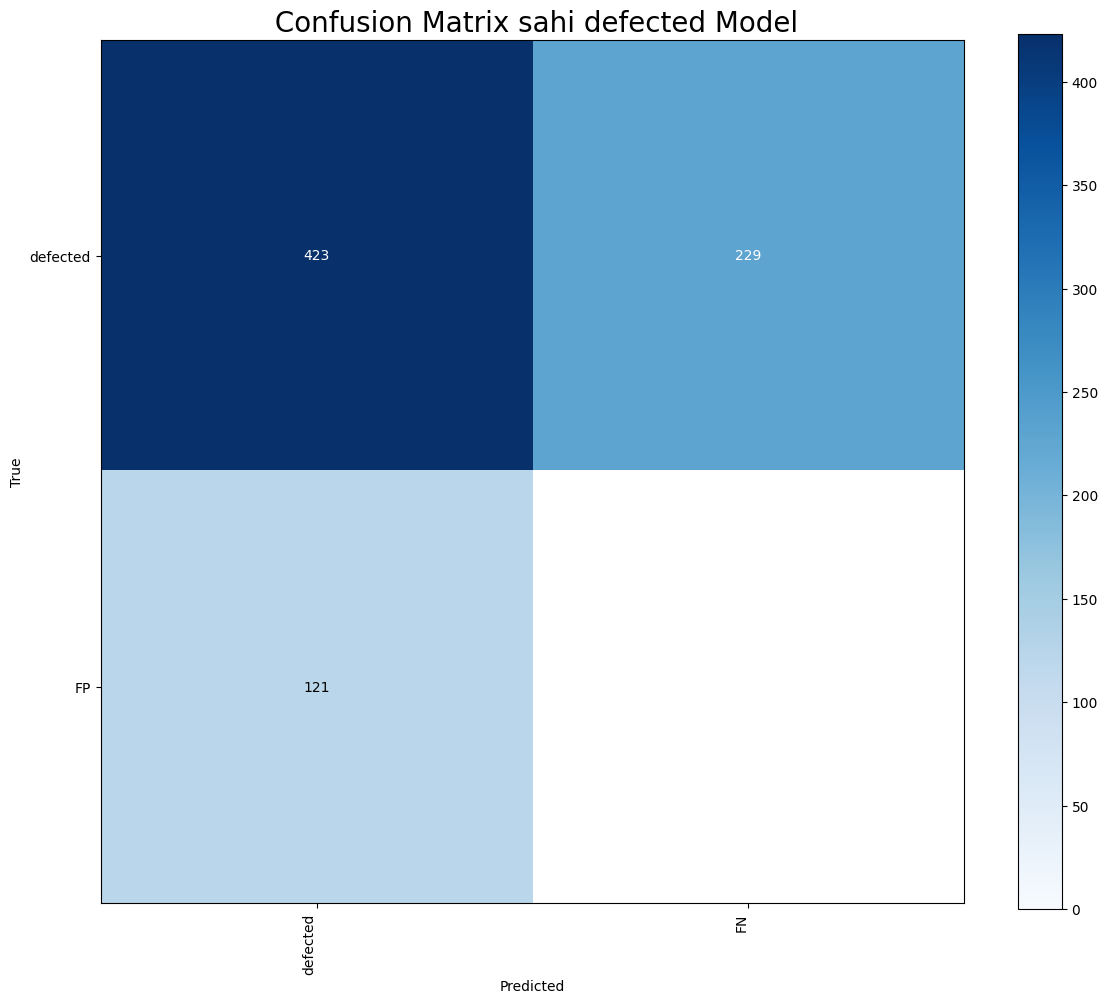

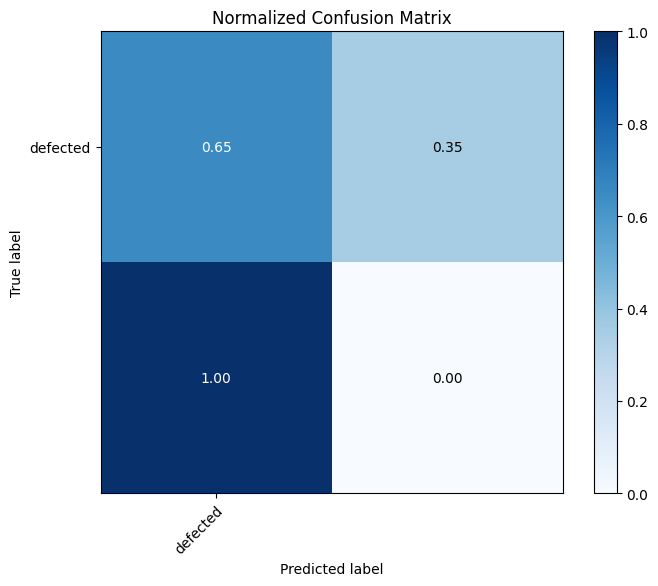

metrics defected tiles:
Precision: 0.7776
Recall: 0.6488
F1-Score: 0.7074
 

0: 512x640 (no detections), 11.5ms
Speed: 4.3ms preprocess, 11.5ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 1 item, 14.0ms
Speed: 4.0ms preprocess, 14.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 5 items, 16.5ms
Speed: 5.7ms preprocess, 16.5ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 17 items, 10.8ms
Speed: 3.7ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 1 item, 14.0ms
Speed: 4.4ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 19 items, 13.6ms
Speed: 4.2ms preprocess, 13.6ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 (no detections), 11.2ms
Speed: 3.6ms preprocess, 11.2ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 (no detections), 13.6

In [ ]:
cm_defected_tiles= plot_CM(callback_with_model_defected_tiles,' Confusion Matrix sahi defected Model',dataset_defected_tiles,False)
plot_normalized_confusion_matrix(cm_defected_tiles)
print("metrics defected tiles:")
calculate_metrics(cm_defected_tiles)
print(" ")
calc_map(callback_with_model_defected_tiles,dataset_defected_tiles)


In [ ]:
cm_defected_sahi= plot_CM(callback_defected_sahi,' Confusion Matrix sahi defected Model',dataset_defected,False)
plot_normalized_confusion_matrix(cm_defected_sahi)
print("metrics both:")
calculate_metrics(cm_defected_sahi)
print(" ")



0: 640x640 26 items, 15.6ms
Speed: 15.1ms preprocess, 15.6ms inference, 42.5ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 23 items, 67.4ms
Speed: 6.0ms preprocess, 67.4ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 27 items, 52.0ms
Speed: 3.3ms preprocess, 52.0ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 20 items, 16.2ms
Speed: 3.7ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 13 items, 15.6ms
Speed: 3.5ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)

0: 544x640 4 items, 63.4ms
Speed: 4.2ms preprocess, 63.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 9 items, 64.0ms
Speed: 3.7ms preprocess, 64.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 40 items, 13.1ms
Speed: 3.1ms preprocess, 13.1ms inference, 1.2ms postprocess per image at shape (1, 3, 51

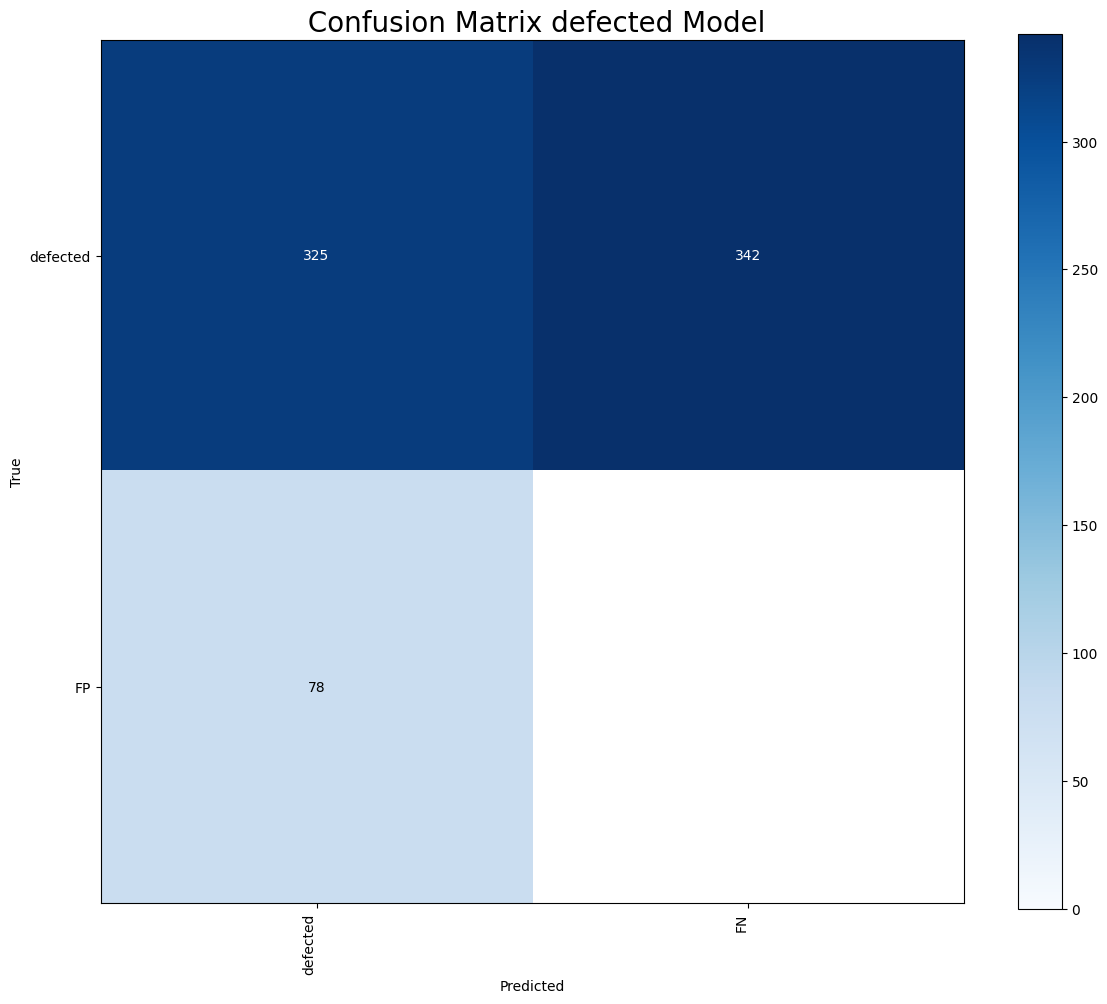

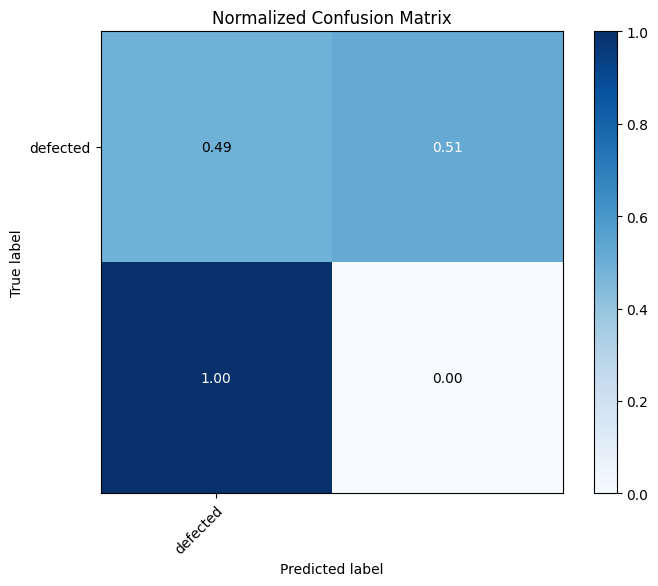

metrics :
Precision: 0.8065
Recall: 0.4873
F1-Score: 0.6075
 


In [ ]:
#model_defected=model_defected_transfer_learning
model_defected= YOLO(model_defected_path)
cm_defected= plot_CM(callback_with_model_defected,' Confusion Matrix defected Model',dataset_defected,False)
plot_normalized_confusion_matrix(cm_defected)
print("metrics :")
calculate_metrics(cm_defected)
print(" ")
# calc_map(callback_with_model_defected,dataset_defected)


0: 512x640 134 items, 50.9ms
Speed: 3.8ms preprocess, 50.9ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 86 items, 16.6ms
Speed: 7.0ms preprocess, 16.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 81 items, 74.5ms
Speed: 5.0ms preprocess, 74.5ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 44 items, 13.6ms
Speed: 4.7ms preprocess, 13.6ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)

0: 608x640 99 items, 79.2ms
Speed: 7.6ms preprocess, 79.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 122 items, 16.0ms
Speed: 6.9ms preprocess, 16.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 97 items, 80.4ms
Speed: 4.6ms preprocess, 80.4ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 85 items, 16.1ms
Speed: 5.4ms preprocess, 16.1ms inference, 0.6ms postprocess per image at shape (1, 3, 

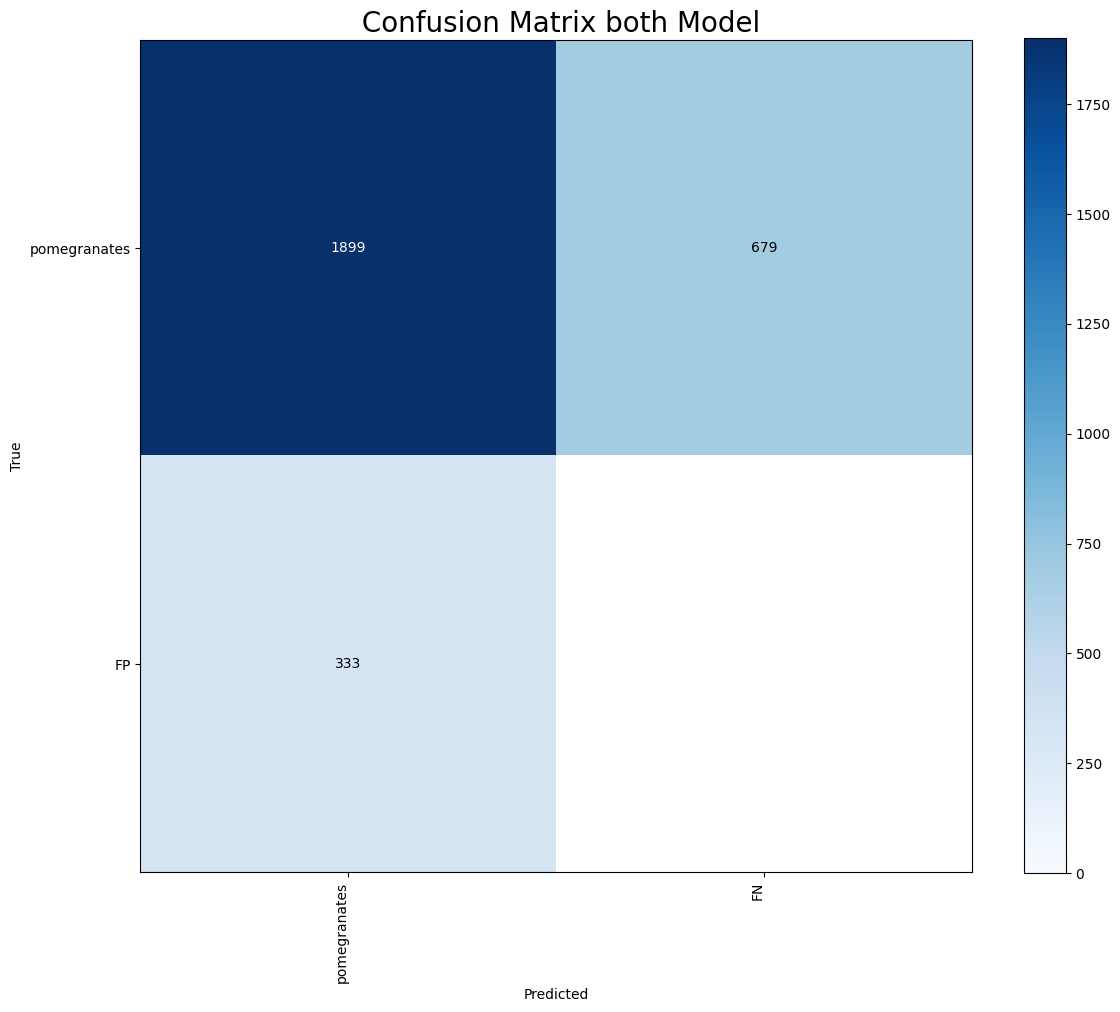

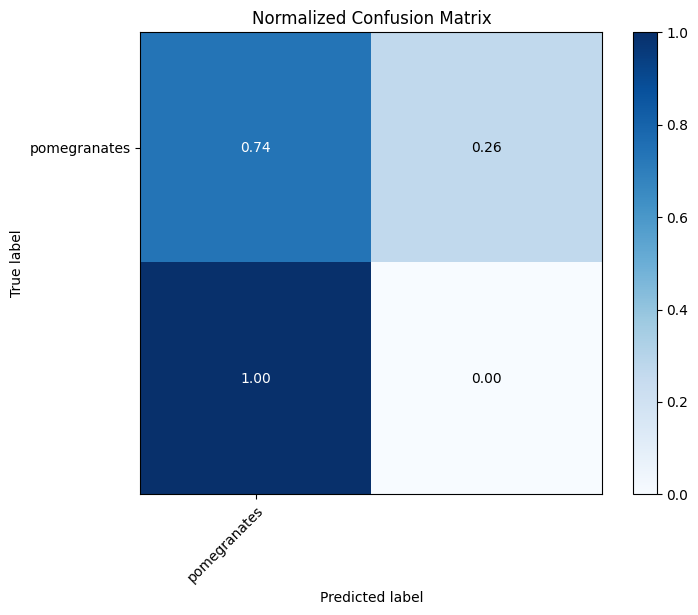

metrics :
Precision: 0.8508
Recall: 0.7366
F1-Score: 0.7896
 

0: 512x640 134 items, 12.7ms
Speed: 4.1ms preprocess, 12.7ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 86 items, 15.7ms
Speed: 4.7ms preprocess, 15.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 81 items, 18.6ms
Speed: 6.6ms preprocess, 18.6ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 44 items, 12.8ms
Speed: 4.1ms preprocess, 12.8ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)

0: 608x640 99 items, 15.2ms
Speed: 4.1ms preprocess, 15.2ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 122 items, 15.8ms
Speed: 4.9ms preprocess, 15.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 97 items, 15.0ms
Speed: 4.9ms preprocess, 15.0ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 85 items, 15.8ms
Speed: 5.0ms preprocess, 

In [ ]:
model_yield= YOLO("/content/runs/detect/train/weights/best.pt")
cm_yield= plot_CM(callback_with_model_yield,' Confusion Matrix both Model',dataset_yield,False)
plot_normalized_confusion_matrix(cm_yield)
print("metrics :")
calculate_metrics(cm_yield)
print(" ")
calc_map(callback_with_model_yield,dataset_yield)



0: 512x640 35 defecteds, 101 pomegranatess, 36.1ms
Speed: 12.9ms preprocess, 36.1ms inference, 4.5ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 7 defecteds, 57 pomegranatess, 12.5ms
Speed: 3.6ms preprocess, 12.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 18 defecteds, 87 pomegranatess, 12.6ms
Speed: 3.3ms preprocess, 12.6ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)

0: 576x640 26 pomegranatess, 15.0ms
Speed: 4.2ms preprocess, 15.0ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 2 defecteds, 72 pomegranatess, 12.5ms
Speed: 3.0ms preprocess, 12.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 8 defecteds, 100 pomegranatess, 14.8ms
Speed: 3.4ms preprocess, 14.8ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)

0: 576x640 9 defecteds, 84 pomegranatess, 14.9ms
Speed: 3.5ms preprocess, 14.9ms inference, 0.4ms postprocess per image at sh

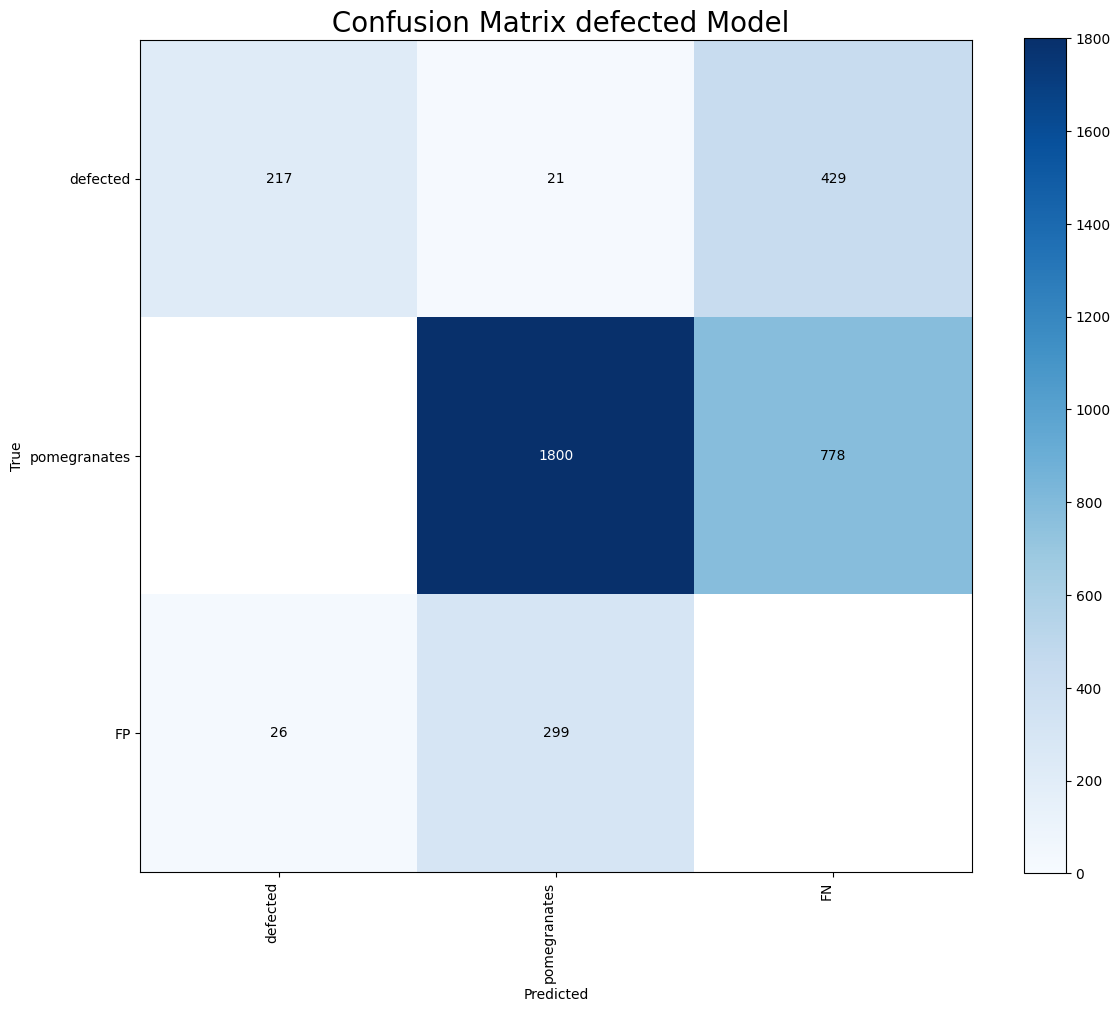

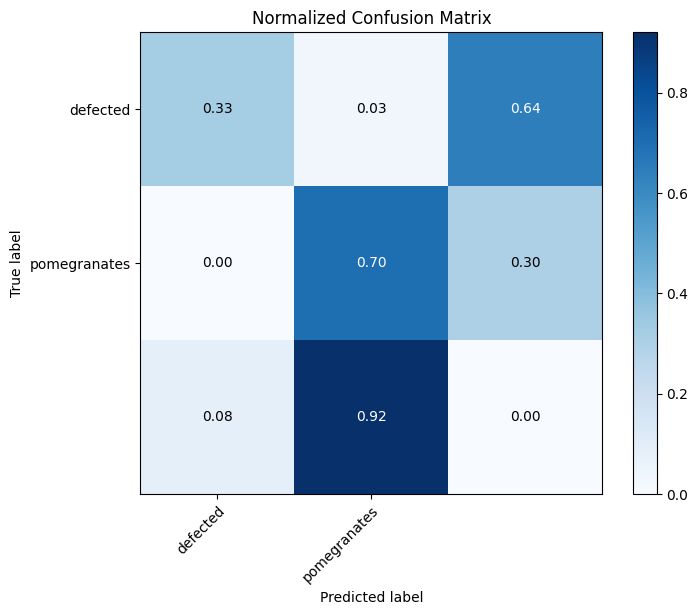

metrics :
Class "Defected": Precision: 0.8930, Recall: 0.3253, F1 Score: 0.4769
Class "Pomegranate": Precision: 0.8491, Recall: 0.6982, F1 Score: 0.7663
Overall Precision: 0.8710
Overall Recall: 0.5118
Overall F1 Score: 0.6216
Overall Accuracy: 0.5650
 

0: 512x640 35 defecteds, 101 pomegranatess, 12.8ms
Speed: 4.0ms preprocess, 12.8ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 7 defecteds, 57 pomegranatess, 12.5ms
Speed: 4.0ms preprocess, 12.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 18 defecteds, 87 pomegranatess, 12.6ms
Speed: 4.3ms preprocess, 12.6ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)

0: 576x640 26 pomegranatess, 15.0ms
Speed: 4.2ms preprocess, 15.0ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 2 defecteds, 72 pomegranatess, 12.5ms
Speed: 3.8ms preprocess, 12.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 8 defecte

In [ ]:
#model_defected=model_defected_transfer_learning
model_both= YOLO("/content/runs/detect/train3/weights/best.pt")
cm_both= plot_CM(callback_with_model_both,' Confusion Matrix defected Model',dataset_both,False)
plot_normalized_confusion_matrix(cm_both)
print("metrics :")
calculate_metrics(cm_both)
print(" ")
calc_map(callback_with_model_both,dataset_both)

In [ ]:
#normalized confusion Matrixes
cm_yiel_norm= plot_CM(callback_with_model_yield,'Normalized Confusion Matrix Yield Model',dataset_yield,True)

cm_defrcted_norm= plot_CM(callback_with_model_defected,'Normalized Confusion Matrix Defected Model',dataset_defected,True)

cm_both_norm= plot_CM(callback_with_model_both,'Normalized Confusion Matrix both Model',dataset_both,True)



In [ ]:
# confusion Matrixes
cm_yield= plot_CM(callback_with_model_yield,' Confusion Matrix Yield Model',dataset_yield,False)

cm_defected= plot_CM(callback_with_model_defected,' Confusion Matrix Defected Model',dataset_defected,False)

cm_both= plot_CM(callback_with_model_both,' Confusion Matrix both Model',dataset_both,False)


In [ ]:
plot_normalized_confusion_matrix(cm_yield)
plot_normalized_confusion_matrix(cm_defected)
plot_normalized_confusion_matrix(cm_both)

In [ ]:
#####לנסות לחשב map
def get_detections(test_images_path, model):
  image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.png'))]
  for img_path in image_files:
      image = cv2.imread(img_path)
      results = model(image)
      detections = sv.Detections.from_ultralytics(results)  # Convert results to Supervision detections format
      print(results)

get_detections(test_images_path, model_yield)

In [ ]:
print("metrics yield:")
calculate_metrics(cm_yield)
print(" ")
print("metrics defected:")
calculate_metrics(cm_defected)
print(" ")
print("metrics both:")
calculate_metrics(cm_both)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#normelized confusion matrix
def plot_normalized_confusion_matrix(confusionMatrix):
    # Extract the matrix and classes from the ConfusionMatrix object
    cm_data = confusionMatrix.matrix
    classes = confusionMatrix.classes

    # Normalize the confusion matrix by row sums (i.e., actual class totals)
    row_sums = cm_data.sum(axis=1, keepdims=True)
    normalized_matrix = cm_data / row_sums
    print(normalized_matrix)
    confusionMatrix.matrix = normalized_matrix
    # Plot the normalized confusion matrix
    # Create a heatmap to visualize the normalized confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.cm.Blues  # Color map for the heatmap
    im = ax.imshow(normalized_matrix, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)  # Add a colorbar to a plot

    # Adding title and labels to the plot
    ax.set(xticks=np.arange(len(classes)),
           yticks=np.arange(len(classes)),
           xticklabels=classes,  # Class labels for predicted (x-axis)
           yticklabels=classes,  # Class labels for true (y-axis)
           title='Normalized Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels for better visibility
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = normalized_matrix.max() / 2.
    for i in range(normalized_matrix.shape[0]):
        for j in range(normalized_matrix.shape[1]):
            ax.text(j, i, format(normalized_matrix[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if normalized_matrix[i, j] > thresh else "black")

    plt.show()
plot_normalized_confusion_matrix(confusion_matrix)


#make synthetic dataset

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="iDAVu5fIQ8b91PndHcMI")
project = rf.workspace("image-proccesing-gsjxv").project("pomegranate-defect-digital-7xn5a")
version = project.version(3)
dataset = version.download("yolov11")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pomegranate-defect(-Digital-)-3 in yolov11:: 100%|██████████| 1110/1110 [00:00<00:00, 8533.99it/s]


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="iDAVu5fIQ8b91PndHcMI")
project = rf.workspace("image-proccesing-gsjxv").project("pomegranate-defect-digital-7xn5a")
version = project.version(4)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pomegranate-defect(-Digital-)-4 in yolov11:: 100%|██████████| 374/374 [00:00<00:00, 9965.44it/s]


segment and make new transfer learning dataset


In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0
HOME = "/content"

!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam =sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
#Generate Segmentation with Bounding Box
mask_predictor = SamPredictor(sam)

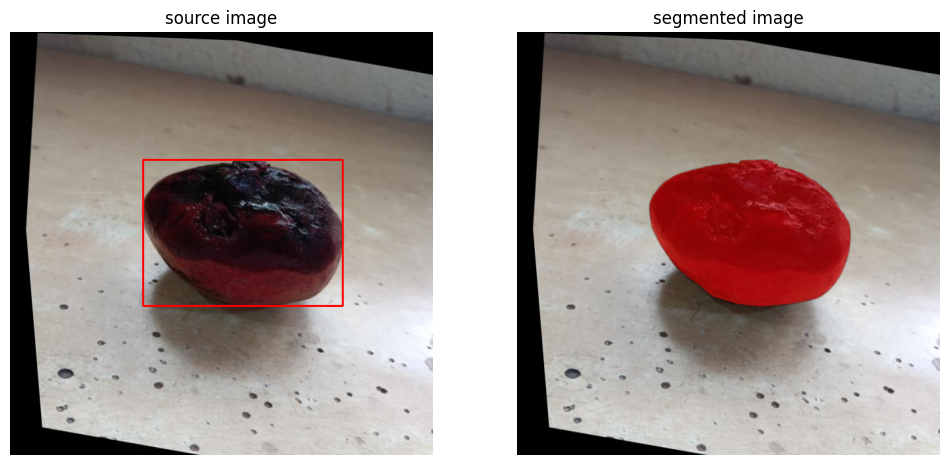

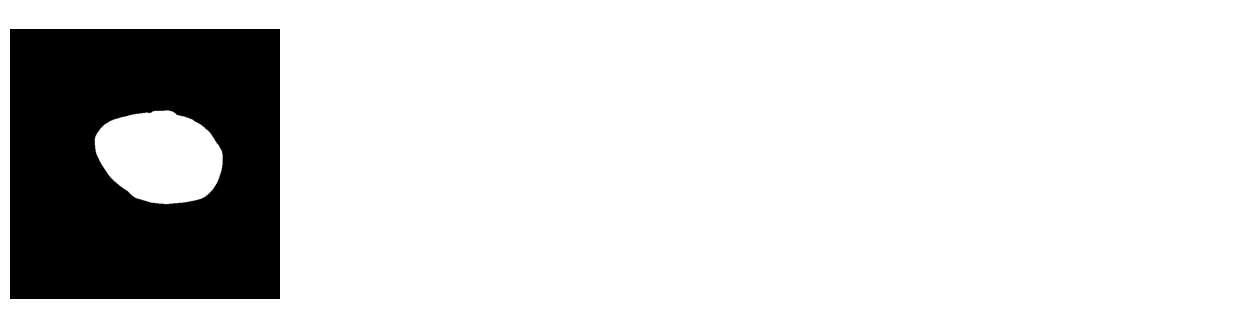

In [ ]:
import supervision as sv
import cv2
import numpy as np

def segment_defected_pomogranate(image_bgr_path, label_path):
  image_bgr = cv2.imread(image_bgr_path)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  h, w = image_rgb.shape[:2]
  mask_predictor.set_image(image_rgb)

  with open(label_path, "r") as f:
      lines = f.readlines()

  for line in lines:
      cls, xc, yc, bw, bh = map(float, line.strip().split())
      x0 = int((xc - bw / 2) * w)
      y0 = int((yc - bh / 2) * h)
      x1 = int((xc + bw / 2) * w)
      y1 = int((yc + bh / 2) * h)

      input_box = np.array([[x0, y0, x1, y1]])
      masks, scores, logits = mask_predictor.predict(
          box=input_box,
          multimask_output=False
      )

      box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
      mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

      detections = sv.Detections(
          xyxy=sv.mask_to_xyxy(masks=masks),
          mask=masks
      )
      detections = detections[detections.area == np.max(detections.area)]

      source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
      segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

      sv.plot_images_grid(
          images=[source_image, segmented_image],
          grid_size=(1, 2),
          titles=['source image', 'segmented image']
      )
      sv.plot_images_grid(
      images=masks,
      grid_size=(1, 4),
      size=(16, 4)
  )


label_path = "/content/pomogranate_def/train/labels/MD-101-d_jpg.rf.072c73f4d8bf3fb7a13d0d1d68409266.txt"
image_bgr_path=  "/content/pomogranate_def/train/images/MD-101-d_jpg.rf.072c73f4d8bf3fb7a13d0d1d68409266.jpg"


segment_defected_pomogranate(image_bgr_path, label_path)

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import random
import supervision as sv

def process_dataset(images_dir, labels_dir, backgrounds_dir, output_images_dir, output_labels_dir):
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    bg_files = [os.path.join(backgrounds_dir, f) for f in os.listdir(backgrounds_dir) if f.lower().endswith((".jpg", ".png"))]
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(".jpg")]

    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)
        label_file = image_file.replace(".jpg", ".txt")
        label_path = os.path.join(labels_dir, label_file)

        if not os.path.exists(label_path):
            continue

        image_bgr = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        h, w = image_rgb.shape[:2]
        mask_predictor.set_image(image_rgb)

        with open(label_path, "r") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            cls, xc, yc, bw, bh = map(float, line.strip().split())
            x0 = int((xc - bw / 2) * w)
            y0 = int((yc - bh / 2) * h)
            x1 = int((xc + bw / 2) * w)
            y1 = int((yc + bh / 2) * h)

            input_box = np.array([[x0, y0, x1, y1]])
            masks, scores, logits = mask_predictor.predict(
                box=input_box,
                multimask_output=False
            )

            best_mask = masks[0].astype(np.uint8) * 255

            image_pil = Image.fromarray(image_rgb).convert("RGBA")
            mask_pil = Image.fromarray(best_mask).convert("L")

            object_rgba = Image.new("RGBA", image_pil.size)
            object_rgba.paste(image_pil, mask=mask_pil)

            bbox = mask_pil.getbbox()
            object_cropped = object_rgba.crop(bbox)




            background_path = random.choice(bg_files)
            background = Image.open(background_path).convert("RGBA")


            # אחוז מהרוחב של תמונת היעד
            target_frac = random.uniform(0.02, 0.05)  # 2% עד 5% מרוחב הרקע

            bg_w, bg_h = background.size
            target_w = int(bg_w * target_frac)

            # שמירת יחס גובה-רוחב
            scale = target_w / object_cropped.width
            target_h = int(object_cropped.height * scale)

            # הגנה מאובייקט זעיר מדי
            target_w = max(5, target_w)
            target_h = max(5, target_h)

            object_resized = object_cropped.resize(
                (target_w, target_h),
                Image.Resampling.LANCZOS
            )

            bg_w, bg_h = background.size
            obj_w, obj_h = object_resized.size
            x_offset = np.random.randint(0, bg_w - obj_w)
            y_offset = np.random.randint(0, bg_h - obj_h)

            background.paste(object_resized, (x_offset, y_offset), mask=object_resized)

            new_image_name = f"{os.path.splitext(image_file)[0]}_aug_{i}.png"
            background.save(os.path.join(output_images_dir, new_image_name))

            new_xc = (x_offset + obj_w / 2) / bg_w
            new_yc = (y_offset + obj_h / 2) / bg_h
            new_bw = obj_w / bg_w
            new_bh = obj_h / bg_h

            with open(os.path.join(output_labels_dir, new_image_name.replace(".png", ".txt")), "w") as out_label_file:
                out_label_file.write(f"{int(cls)} {new_xc} {new_yc} {new_bw} {new_bh}\n")


bg_dir= "/content/drive/MyDrive/thesis_notebook_files/background_images"
img_dir="/content/pomogranate_def/train/images"
labels_dir= "/content/pomogranate_def/train/labels"
output_images_dir="/content/drive/MyDrive/thesis_notebook_files/for_git/synthetic_dataset/images"
output_labels_dir="/content/drive/MyDrive/thesis_notebook_files/for_git/synthetic_dataset/labels"
process_dataset(img_dir, labels_dir, bg_dir, output_images_dir, output_labels_dir)

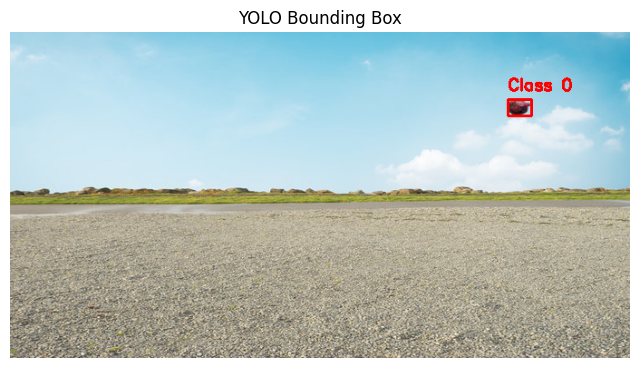

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
#ויזואליזציה
def show_yolo_label_on_image(image_path, label_path):

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    if not os.path.exists(label_path):
        print("Label file not found.")
        return

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, xc, yc, bw, bh = map(float, line.strip().split())
        x0 = int((xc - bw / 2) * w)
        y0 = int((yc - bh / 2) * h)
        x1 = int((xc + bw / 2) * w)
        y1 = int((yc + bh / 2) * h)

        cv2.rectangle(image_rgb, (x0, y0), (x1, y1), color=(255, 0, 0), thickness=2)
        cv2.putText(image_rgb, f"Class {int(cls)}", (x0, y0 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("YOLO Bounding Box")
    plt.show()
image_path= "/content/drive/MyDrive/thesis_notebook_files/for_git/synthetic_dataset/images/MD-113-d_jpg.rf.15686da5c95cefa99732d144fa85a93f_aug_0.png"
label_path= "/content/drive/MyDrive/thesis_notebook_files/for_git/synthetic_dataset/labels/MD-113-d_jpg.rf.15686da5c95cefa99732d144fa85a93f_aug_0.txt"
show_yolo_label_on_image(image_path, label_path)

#sort tracker

In [ ]:
#######מתוקןןןן
import supervision as sv
from trackers import SORTTracker
from ultralytics import YOLO
import cv2
import os

# מחלקה שמרחיבה את SORTTracker ושומרת רשימה של כל הטרקרים שהיו אי פעם
class MySORTTracker(SORTTracker):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Use a set to store unique track IDs for efficient checking
        self.all_track_ids = set()

    def update(self, detections):
        active_tracks = super().update(detections)  # הטרקרים הפעילים כרגע

        # Iterate through the detections with assigned tracker_ids
        if active_tracks.tracker_id is not None:
            for i in range(len(active_tracks)):
                track_id = active_tracks.tracker_id[i]
                # Add the track_id to the set if it's new
                if track_id not in self.all_track_ids:
                    self.all_track_ids.add(track_id)


        return active_tracks





Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#make videos/ frames for validation

In [ ]:
import pandas as pd
import subprocess
import os

def make_tree_video(original_video_path, short_video_path, start_sec, duration, side):
    command = [
        "ffmpeg",
        "-y",                      # overwrite output if exists
        "-i", original_video_path, # input video
        "-ss", str(start_sec),     # start time
        "-t", str(duration),       # duration
        "-map", "0:v:0",           # first video stream
        "-c:v", "copy",            # copy video without re encoding
        "-movflags", "+faststart", # optimize MP4 for playback
        short_video_path
    ]

    res = subprocess.run(command, capture_output=True, text=True)

    if res.returncode != 0:
        print(f"ffmpeg failed for {short_video_path}")
        print(res.stderr)
        return False

    print(f"Created: {short_video_path}")
    return True


def process_excel_and_save_clips(excel_path, videos_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    df = pd.read_excel(excel_path)

    required_cols = ["video", "plot", "side_to_cut", "tree", "start_sec", "end_sec"]

    for idx, row in df.iterrows():
        # skip rows with missing data
        if any(pd.isna(row[col]) for col in required_cols):
            print(f"Skipping row {idx} because of NaN in one of {required_cols}")
            continue

        video_name = str(row["video"])
        plot = str(row["plot"])
        side = str(row["side_to_cut"])
        tree = str(row["tree"])

        try:
            start_sec = float(row["start_sec"])
            end_sec = float(row["end_sec"])
        except ValueError:
            print(f"Skipping row {idx}, could not convert start_sec or end_sec to float")
            continue

        duration = end_sec - start_sec
        if duration <= 0:
            print(f"Skipping row {idx}, non positive duration: {duration}")
            continue

        original_video_path = os.path.join(videos_folder, f"{video_name}.MP4")
        if not os.path.exists(original_video_path):
            print(f"Skipping row {idx}, video file not found: {original_video_path}")
            continue

        short_video_path = os.path.join(
            output_folder,
            f"{tree}_{side}_{plot}_org_vid_{video_name}.mp4"
        )

        ok = make_tree_video(original_video_path, short_video_path, start_sec, duration, side)
        if not ok:
            print(f"Skipping row {idx} because ffmpeg failed")
            continue

# === MAIN ===
excel_path_tsora = "/content/drive/MyDrive/thesis_notebook_files/trees_to_cut/video_sec_to_cur_per_tree_tsora_fixed.xlsx"
excel_path_mh = "/content/drive/MyDrive/thesis_notebook_files/trees_to_cut/mishmar_hanegev_trees_to_cut_fixed.xlsx"
videos_folder_tsora = "/content/drive/MyDrive/thesis_notebook_files/251020m2/tsora_2025_forward_all_rows"

videos_folder_mh = "/content/drive/MyDrive/thesis_notebook_files/סרטוני רחפן רהט/rht/mishmar_hanegav_forward"

output_folder_mh = "/content/drive/MyDrive/thesis_notebook_files/cropped_tree_videos_mh_suf_all_18_12"
output_folder_tsora = "/content/drive/MyDrive/thesis_notebook_files/cropped_tree_videos_tsora_suf_18_12"

# Run for both excels

process_excel_and_save_clips(excel_path_mh, videos_folder_mh, output_folder_mh)
# process_excel_and_save_clips(excel_path_tsora, videos_folder_tsora, output_folder_tsora)

In [ ]:
import os
import math
import pandas as pd
import subprocess

def extract_evenly_spaced_frames(excel_path, video_path, output_dir):
    """
Extracts frames_to_crop uniformly spaced frames in time between random_from and random_to for each row in the Excel file.
Required Excel columns: random_from, random_to, frames_to_crop.
    """
    os.makedirs(output_dir, exist_ok=True)
    df = pd.read_excel(excel_path)

    video_name = os.path.splitext(os.path.basename(video_path))[0]
    video_out_dir = os.path.join(output_dir, video_name)
    os.makedirs(video_out_dir, exist_ok=True)

    for idx, row in df.iterrows():
        start = float(row["random_from"])
        end   = float(row["random_to"])
        n     = int(row["frames_to_crop"])

        if end <= start or n <= 0:
            print(f"⚠️ row {idx+1} skip")
            continue

        duration = end - start

        fps_target = n / duration

        # To avoid always taking the beginning of the range, start in the middle of the first step
        # If there is only one frame, choose the center of the range
        if n == 1:
            seek_start = start + duration * 0.5
        else:
            step = duration / n
            seek_start = start + 0.5 * step

        if seek_start >= end:
            seek_start = start


        remaining = max(0.01, end - seek_start)
        pattern = os.path.join(video_out_dir, f"row{idx+1}_frame_%02d.jpg")

        cmd = [
            "ffmpeg", "-hide_banner", "-loglevel", "error",
            "-y",
            "-ss", f"{seek_start:.3f}",
            "-i", video_path,
            "-t", f"{remaining:.3f}",
            "-an", "-sn",
            "-map", "0:v:0",
            "-vf", f"fps=fps={fps_target:.8f}",
            "-vsync", "vfr",
            "-vframes", str(n),
            "-q:v", "3",
            pattern
        ]

        res = subprocess.run(cmd, capture_output=True, text=True)
        if res.returncode != 0:
            print(f"row {idx+1} failed:\n{res.stderr}")
        else:
            print(f"Row {idx+1}: saved up to {n} frames to {video_out_dir}")


excel_path = "/content/losses_for_frame_crop.xlsx"
video_path = "/content/drive/MyDrive/thesis_notebook_files/251020m2/tsora_2025_row_15/row_15_losses_high.MP4"
output_dir = "/content/drive/MyDrive/thesis_notebook_files/251020m2/even_frames"

extract_evenly_spaced_frames(excel_path, video_path, output_dir)


#tracking


######## running all over the videos


In [ ]:
import os
import re
import glob
import cv2
import numpy as np
import pandas as pd
import supervision as sv

from ultralytics import YOLO
from trackers import SORTTracker

# ---------- Tracker that remembers all tracks ----------
class CountSORTTracker(SORTTracker):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.all_track_ids = set()

    def update(self, detections: sv.Detections):
        active_tracks = super().update(detections)
        if active_tracks.tracker_id is not None:
            for i in range(len(active_tracks)):
                tid = active_tracks.tracker_id[i]
                self.all_track_ids.add(int(tid))
        return active_tracks

# ---------- Optional helpers you already have ----------

def split_detections_by_side(detections: sv.Detections, frame_width: int, margin_px: int = 0):
    """Split detections to left/right by bbox center. Returns det_left, det_right."""
    if len(detections) == 0:
        return sv.Detections.empty(), sv.Detections.empty()
    half = frame_width / 2.0
    keep_l, keep_r = [], []
    for i, (x1, y1, x2, y2) in enumerate(detections.xyxy):
        cx = 0.5 * (x1 + x2)
        if cx <= (half - margin_px):
            keep_l.append(i)
        elif cx >= (half + margin_px):
            keep_r.append(i)
        # if center is inside the margin strip - drop it from both
    det_l = detections[np.array(keep_l, dtype=int)] if keep_l else sv.Detections.empty()
    det_r = detections[np.array(keep_r, dtype=int)] if keep_r else sv.Detections.empty()
    return det_l, det_r

# ---------- Filename parser ----------
def parse_video_name(fname: str):
    """
    Example filename:
    1_r_mishmar_hanegev_11_org_vid_row_9_plot_11_1_first_forward.mp4

    Returns:
        tree (int)
        side (str: 'l' or 'r')
        plot (str)
    """
    base = os.path.basename(fname)
    name, _ = os.path.splitext(base)
    parts = name.split("_")

    if len(parts) < 3:
        raise ValueError(f"Unexpected video name format: {base}")
    # Extract tree number
    tree_str = parts[0]
    tree = int(re.sub(r"\D", "", tree_str))
    # Extract side
    side = parts[1].lower()
    if side not in ("l", "r"):
        raise ValueError(f"Side should be 'l' or 'r' in: {base}")
    # Extract plot name from parts until reaching the keyword 'org'
    plot_parts = []
    i = 2
    while i < len(parts) and parts[i] != "org":
        plot_parts.append(parts[i])
        i += 1
    if not plot_parts:
        raise ValueError("Plot could not be identified from filename")
    plot = "_".join(plot_parts)
    return tree, side, plot

# ---------- Main folder processor ----------
def process_videos_folder(
    folder_path: str,
    output_video_dir: str,
    results_csv_path: str,
    model_defected_path: str,
    model_healthy_path: str
):
    """
    Runs tracking and counting for each video in folder_path.
    Infers side to count from file name.
    Saves per-video output mp4s to output_video_dir and a results CSV to results_csv_path.
    """
    os.makedirs(output_video_dir, exist_ok=True)

    # Load models once
    model_defected = YOLO(model_defected_path)
    model_healthy  = YOLO(model_healthy_path)

    results = []

    # Iterate videos (common extensions)
    video_paths = sorted(
        glob.glob(os.path.join(folder_path, "*.mp4"))
        + glob.glob(os.path.join(folder_path, "*.MP4"))
        + glob.glob(os.path.join(folder_path, "*.mov"))
        + glob.glob(os.path.join(folder_path, "*.MOV"))
    )

    if not video_paths:
        raise FileNotFoundError(f"No videos found under: {folder_path}")

    for vpath in video_paths:
        try:
            tree, side_flag, plot = parse_video_name(vpath)
        except Exception as e:
            print(f"Skipping {vpath} due to name parse error: {e}")
            continue

        # Determine side to count
        side_to_count = "l" if side_flag == "l" else "r"

        # Read fps once for the trackers
        cap = cv2.VideoCapture(vpath)
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.release()
        if not fps or fps <= 0:
            fps = 30.0  # fallback

        # Create fresh trackers per video - to keep counts independent
        tracker_def_display = MySORTTracker(frame_rate=fps, minimum_iou_threshold=0.1, minimum_consecutive_frames=3,
                                            track_activation_threshold=0.4, lost_track_buffer=10)
        tracker_hea_display = MySORTTracker(frame_rate=fps, minimum_iou_threshold=0.1, minimum_consecutive_frames=3,
                                            track_activation_threshold=0.2, lost_track_buffer=10)

        tracker_def_L = MySORTTracker(frame_rate=fps, minimum_iou_threshold=0.1, minimum_consecutive_frames=3,
                                      track_activation_threshold=0.4, lost_track_buffer=10)
        tracker_def_R = MySORTTracker(frame_rate=fps, minimum_iou_threshold=0.1, minimum_consecutive_frames=3,
                                      track_activation_threshold=0.4, lost_track_buffer=10)
        tracker_hea_L = MySORTTracker(frame_rate=fps, minimum_iou_threshold=0.1, minimum_consecutive_frames=4,
                                      track_activation_threshold=0.3, lost_track_buffer=10)
        tracker_hea_R = MySORTTracker(frame_rate=fps, minimum_iou_threshold=0.1, minimum_consecutive_frames=4,
                                      track_activation_threshold=0.3, lost_track_buffer=10)

        # Annotators
        annotator_def = sv.LabelAnnotator(color=sv.Color.RED, text_position=sv.Position.BOTTOM_CENTER)
        box_def       = sv.BoxAnnotator(color=sv.Color.RED)
        annotator_hea = sv.LabelAnnotator(color=sv.Color.GREEN, text_position=sv.Position.BOTTOM_CENTER)
        box_hea       = sv.BoxAnnotator(color=sv.Color.GREEN)

        # Callback factory that closes over side_to_count and trackers
        def make_callback():
            def callback(frame_bgr, frame_index: int):
                H, W = frame_bgr.shape[:2]

                # Preprocess - assumes you have these functions defined
                image_rgb   = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                clahe_image = apply_clahe(image_rgb)
                final_image = enhance_saturation(clahe_image)
                proc_bgr    = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)

                # Detect
                res_def = model_defected(proc_bgr, conf=0.65, iou=0.3)[0]
                det_def = sv.Detections.from_ultralytics(res_def)

                res_hea = model_healthy(proc_bgr,conf=0.2)[0]
                det_hea = sv.Detections.from_ultralytics(res_hea)

                # Update display trackers - both sides shown
                det_def_disp = tracker_def_display.update(det_def)
                det_hea_disp = tracker_hea_display.update(det_hea)

                # Update side-only trackers for counting
                det_def_L, det_def_R = split_detections_by_side(det_def, frame_width=W, margin_px=0)
                det_hea_L, det_hea_R = split_detections_by_side(det_hea, frame_width=W, margin_px=0)
                tracker_def_L.update(det_def_L)
                tracker_def_R.update(det_def_R)
                tracker_hea_L.update(det_hea_L)
                tracker_hea_R.update(det_hea_R)

                # Pick side totals
                if side_to_count == "l":
                    total_yield = len(tracker_hea_L.all_track_ids)
                    total_loss  = len(tracker_def_L.all_track_ids)
                    side_str    = "Left"
                else:
                    total_yield = len(tracker_hea_R.all_track_ids)
                    total_loss  = len(tracker_def_R.all_track_ids)
                    side_str    = "Right"

                # Draw
                out = proc_bgr.copy()

                # Build labels as strings from tracker ids (fix for new supervision)
                if det_def_disp.tracker_id is not None:
                    def_labels = [str(tid) for tid in det_def_disp.tracker_id]
                else:
                    def_labels = None

                if det_hea_disp.tracker_id is not None:
                    hea_labels = [str(tid) for tid in det_hea_disp.tracker_id]
                else:
                    hea_labels = None

                out = annotator_def.annotate(out, det_def_disp, labels=def_labels)
                out = box_def.annotate(out, detections=det_def_disp)
                out = annotator_hea.annotate(out, det_hea_disp, labels=hea_labels)
                out = box_hea.annotate(out, detections=det_hea_disp)

                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(out, f"Total yield ({side_str} only): {total_yield}", (10, 40), font, 1.0, (0,255,0), 2)
                cv2.putText(out, f"Total fruit loss ({side_str} only): {total_loss}", (10, 70), font, 1.0, (0,0,255), 2)
                cv2.line(out, (W//2, 0), (W//2, H), (255, 255, 255), 2)

                return out
            return callback

        # Output video path
        out_name = os.path.basename(vpath)
        out_path = os.path.join(output_video_dir, out_name)

        # Run processing
        sv.process_video(
            source_path=vpath,
            target_path=out_path,
            callback=make_callback(),
        )

        # After video ends - finalize counts on the chosen side
        if side_to_count == "l":
            yield_count = len(tracker_hea_L.all_track_ids)
            loss_count  = len(tracker_def_L.all_track_ids)
            side_label  = "left"
        else:
            yield_count = len(tracker_hea_R.all_track_ids)
            loss_count  = len(tracker_def_R.all_track_ids)
            side_label  = "right"

        results.append({
            "tree_number": tree,
            "side_of_filming": side_label,
            "yield_count": int(yield_count),
            "loss_count": int(loss_count),
            "plot": plot,
            "video_name": os.path.basename(vpath)
        })

        print(f"Done: {vpath} -> yield={yield_count}, loss={loss_count}, side={side_label}")

    # Save results table separately
    df = pd.DataFrame(results).sort_values(by=["plot", "tree_number", "video_name"])
    os.makedirs(os.path.dirname(results_csv_path), exist_ok=True)
    df.to_csv(results_csv_path, index=False)
    print(f"\n✅ Saved results table to: {results_csv_path}")

# ---------- Example usage ----------
folder_path = "/content/drive/MyDrive/thesis_notebook_files/251020m2/tsora_2025_trees_cropepd_with_org_vid_suf"
output_video_dir = "/content/drive/MyDrive/thesis_notebook_files/outputs_tsora_yolo11s_finetuned_d_conf_065_y_conf03"
results_csv_path = "/content/drive/MyDrive/thesis_notebook_files/outputs_tsora_yolo11s_finetuned_d_conf_65_y_conf3/results.csv"

# folder_path = "/content/drive/MyDrive/thesis_notebook_files/mishmar_hanegev_tree_videos_with_org_vid_suf"
# output_video_dir = "/content/drive/MyDrive/thesis_notebook_files/outputs_per_mishmarhanegev_yolo11s_finetuned"
# results_csv_path = "/content/drive/MyDrive/thesis_notebook_files/outputs_per_mishmarhanegev_yolo11s_finetuned/results.csv"

model_defected_path = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_defected_after_finetuning_15_epocs/weights/best.pt"
# model_defected_path = "/content/drive/MyDrive/thesis_notebook_files/model_defected_yolo11s_100_epochs_v21_agumentation_fixed_not_doubled/weights/best.pt"
model_healthy_path  = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_yield_100_epochs/weights/best.pt"

process_videos_folder(
    folder_path=folder_path,
    output_video_dir=output_video_dir,
    results_csv_path=results_csv_path,
    model_defected_path=model_defected_path,
    model_healthy_path=model_healthy_path
)


In [ ]:
###### one side trackers
import os
import re
import glob
import cv2
import numpy as np
import pandas as pd
import supervision as sv

from ultralytics import YOLO
from trackers import SORTTracker


# ---------- Tracker that remembers all tracks ----------
class CountSORTTracker(SORTTracker):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.all_track_ids = set()

    def update(self, detections: sv.Detections):
        active_tracks = super().update(detections)
        if active_tracks.tracker_id is not None:
            for i in range(len(active_tracks)):
                tid = active_tracks.tracker_id[i]
                self.all_track_ids.add(int(tid))
        return active_tracks


# ---------- Optional helpers you already have ----------
def split_detections_by_side(detections: sv.Detections, frame_width: int, margin_px: int = 0):
    """Split detections to left/right by bbox center. Returns det_left, det_right."""
    if len(detections) == 0:
        return sv.Detections.empty(), sv.Detections.empty()
    half = frame_width / 2.0
    keep_l, keep_r = [], []
    for i, (x1, y1, x2, y2) in enumerate(detections.xyxy):
        cx = 0.5 * (x1 + x2)
        if cx <= (half - margin_px):
            keep_l.append(i)
        elif cx >= (half + margin_px):
            keep_r.append(i)
        # if center is inside the margin strip - drop it from both
    det_l = detections[np.array(keep_l, dtype=int)] if keep_l else sv.Detections.empty()
    det_r = detections[np.array(keep_r, dtype=int)] if keep_r else sv.Detections.empty()
    return det_l, det_r


# ---------- Filename parser ----------
def parse_video_name(fname: str):
    """
    Example filename:
    1_r_mishmar_hanegev_11_org_vid_row_9_plot_11_1_first_forward.mp4

    Returns:
        tree (int)
        side (str: 'l' or 'r')
        plot (str)
    """
    base = os.path.basename(fname)
    name, _ = os.path.splitext(base)
    parts = name.split("_")

    if len(parts) < 3:
        raise ValueError(f"Unexpected video name format: {base}")
    # Extract tree number
    tree_str = parts[0]
    tree = int(re.sub(r"\D", "", tree_str))
    # Extract side
    side = parts[1].lower()
    if side not in ("l", "r"):
        raise ValueError(f"Side should be 'l' or 'r' in: {base}")
    # Extract plot name from parts until reaching the keyword 'org'
    plot_parts = []
    i = 2
    while i < len(parts) and parts[i] != "org":
        plot_parts.append(parts[i])
        i += 1
    if not plot_parts:
        raise ValueError("Plot could not be identified from filename")
    plot = "_".join(plot_parts)
    return tree, side, plot


# ---------- Main folder processor ----------
def process_videos_folder(
    folder_path: str,
    output_video_dir: str,
    results_csv_path: str,
    model_defected_path: str,
    model_healthy_path: str
):
    """
    Runs tracking and counting for each video in folder_path.
    Infers side to count from file name.
    Saves per-video output mp4s to output_video_dir and a results CSV to results_csv_path.
    """
    os.makedirs(output_video_dir, exist_ok=True)

    # Load models once
    model_defected = YOLO(model_defected_path)
    model_healthy = YOLO(model_healthy_path)

    results = []

    # Iterate videos (common extensions)
    video_paths = sorted(
        glob.glob(os.path.join(folder_path, "*.mp4"))
        + glob.glob(os.path.join(folder_path, "*.MP4"))
        + glob.glob(os.path.join(folder_path, "*.mov"))
        + glob.glob(os.path.join(folder_path, "*.MOV"))
    )

    if not video_paths:
        raise FileNotFoundError(f"No videos found under: {folder_path}")

    for vpath in video_paths:
        try:
            tree, side_flag, plot = parse_video_name(vpath)
        except Exception as e:
            print(f"Skipping {vpath} due to name parse error: {e}")
            continue

        # Determine side to count
        side_to_count = "l" if side_flag == "l" else "r"

        # Read fps once for the trackers
        cap = cv2.VideoCapture(vpath)
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.release()
        if not fps or fps <= 0:
            fps = 30.0  # fallback

        # Create fresh trackers per video - to keep counts independent
        tracker_def_L = MySORTTracker(
            frame_rate=fps,
            minimum_iou_threshold=0.1,
            minimum_consecutive_frames=3,
            track_activation_threshold=0.4,
            lost_track_buffer=10,
        )
        tracker_def_R = MySORTTracker(
            frame_rate=fps,
            minimum_iou_threshold=0.1,
            minimum_consecutive_frames=3,
            track_activation_threshold=0.4,
            lost_track_buffer=10,
        )
        tracker_hea_L = MySORTTracker(
            frame_rate=fps,
            minimum_iou_threshold=0.1,
            minimum_consecutive_frames=4,
            track_activation_threshold=0.4,
            lost_track_buffer=10,
        )
        tracker_hea_R = MySORTTracker(
            frame_rate=fps,
            minimum_iou_threshold=0.1,
            minimum_consecutive_frames=4,
            track_activation_threshold=0.4,
            lost_track_buffer=10,
        )

        # Annotators
        annotator_def = sv.LabelAnnotator(color=sv.Color.RED, text_position=sv.Position.BOTTOM_CENTER)
        box_def = sv.BoxAnnotator(color=sv.Color.RED)
        annotator_hea = sv.LabelAnnotator(color=sv.Color.GREEN, text_position=sv.Position.BOTTOM_CENTER)
        box_hea = sv.BoxAnnotator(color=sv.Color.GREEN)

        # Callback factory that closes over side_to_count and trackers
        def make_callback():
            def callback(frame_bgr, frame_index: int):
                H, W = frame_bgr.shape[:2]

                # preprocess
                image_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                clahe_image = apply_clahe(image_rgb)
                final_image = enhance_saturation(clahe_image)
                proc_bgr = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)

                # detect
                res_def = model_defected(proc_bgr, conf=0.65, iou=0.3)[0]
                det_def = sv.Detections.from_ultralytics(res_def)

                res_hea = model_healthy(proc_bgr, conf=0.3)[0]
                det_hea = sv.Detections.from_ultralytics(res_hea)

                # split by side BEFORE tracking
                det_def_L_raw, det_def_R_raw = split_detections_by_side(det_def, frame_width=W, margin_px=0)
                det_hea_L_raw, det_hea_R_raw = split_detections_by_side(det_hea, frame_width=W, margin_px=0)

                # update trackers per side, and get tracked detections (עם tracker_id)
                tracked_def_L = tracker_def_L.update(det_def_L_raw)
                tracked_def_R = tracker_def_R.update(det_def_R_raw)
                tracked_hea_L = tracker_hea_L.update(det_hea_L_raw)
                tracked_hea_R = tracker_hea_R.update(det_hea_R_raw)

                # counts לפי הצד הנספר בלבד
                if side_to_count == "l":
                    total_yield = len(tracker_hea_L.all_track_ids)
                    total_loss = len(tracker_def_L.all_track_ids)
                    side_str = "Left"
                else:
                    total_yield = len(tracker_hea_R.all_track_ids)
                    total_loss = len(tracker_def_R.all_track_ids)
                    side_str = "Right"

                out = proc_bgr.copy()

                # labels left
                if tracked_def_L.tracker_id is not None:
                    def_labels_L = [str(tid) for tid in tracked_def_L.tracker_id]
                else:
                    def_labels_L = None

                if tracked_hea_L.tracker_id is not None:
                    hea_labels_L = [str(tid) for tid in tracked_hea_L.tracker_id]
                else:
                    hea_labels_L = None

                # labels right
                if tracked_def_R.tracker_id is not None:
                    def_labels_R = [str(tid) for tid in tracked_def_R.tracker_id]
                else:
                    def_labels_R = None

                if tracked_hea_R.tracker_id is not None:
                    hea_labels_R = [str(tid) for tid in tracked_hea_R.tracker_id]
                else:
                    hea_labels_R = None

                # draw left
                out = annotator_def.annotate(out, tracked_def_L, labels=def_labels_L)
                out = box_def.annotate(out, detections=tracked_def_L)

                out = annotator_hea.annotate(out, tracked_hea_L, labels=hea_labels_L)
                out = box_hea.annotate(out, detections=tracked_hea_L)

                # draw right
                out = annotator_def.annotate(out, tracked_def_R, labels=def_labels_R)
                out = box_def.annotate(out, detections=tracked_def_R)

                out = annotator_hea.annotate(out, tracked_hea_R, labels=hea_labels_R)
                out = box_hea.annotate(out, detections=tracked_hea_R)

                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(out, f"Total yield ({side_str} only): {total_yield}", (10, 40), font, 1.0, (0, 255, 0), 2)
                cv2.putText(out, f"Total fruit loss ({side_str} only): {total_loss}", (10, 70), font, 1.0, (0, 0, 255), 2)
                cv2.line(out, (W // 2, 0), (W // 2, H), (255, 255, 255), 2)

                return out

            return callback

        # Output video path
        out_name = os.path.basename(vpath)
        out_path = os.path.join(output_video_dir, out_name)

        # Run processing
        sv.process_video(
            source_path=vpath,
            target_path=out_path,
            callback=make_callback(),
        )

        # After video ends - finalize counts on the chosen side
        if side_to_count == "l":
            yield_count = len(tracker_hea_L.all_track_ids)
            loss_count = len(tracker_def_L.all_track_ids)
            side_label = "left"
        else:
            yield_count = len(tracker_hea_R.all_track_ids)
            loss_count = len(tracker_def_R.all_track_ids)
            side_label = "right"

        results.append({
            "tree_number": tree,
            "side_of_filming": side_label,
            "yield_count": int(yield_count),
            "loss_count": int(loss_count),
            "plot": plot,
            "video_name": os.path.basename(vpath),
        })

        print(f"Done: {vpath} -> yield={yield_count}, loss={loss_count}, side={side_label}")

    # Save results table separately
    df = pd.DataFrame(results).sort_values(by=["plot", "tree_number", "video_name"])
    os.makedirs(os.path.dirname(results_csv_path), exist_ok=True)
    df.to_csv(results_csv_path, index=False)
    print(f"\n✅ Saved results table to: {results_csv_path}")


# ---------- Example usage ----------
folder_path_tsora = "/content/drive/MyDrive/thesis_notebook_files/cropped_tree_videos_tsora_suf_18_12"
output_video_dir_tsora = "/content/drive/MyDrive/thesis_notebook_files/outputs_tsora_yolo11s_finetuned_d_conf_065_y_conf03_track_thresh04_min_frame4_no_disptracker_20_12_fixed_tsora_video"
results_csv_path_tsora = "/content/drive/MyDrive/thesis_notebook_files/outputs_tsora_yolo11s_finetuned_d_conf_065_y_conf03_track_thresh04_min_frame4_no_disptracker_20_12_fixed_tsora_video/results.csv"


folder_path_mh = "/content/drive/MyDrive/thesis_notebook_files/cropped_tree_videos_mh_suf_all"
output_video_dir_mh = "/content/drive/MyDrive/thesis_notebook_files/outputs_per_mishmarhanegev_yolo11s_finetuned_d_conf_065_y_conf03_track_thresh04_min_frame4_no_disptracker_fixed_videos_t"
results_csv_path_mh = "/content/drive/MyDrive/thesis_notebook_files/outputs_per_mishmarhanegev_yolo11s_finetuned_d_conf_065_y_conf03_track_thresh04_min_frame4_no_disptracker_fixed_videos_t/results.csv"

model_defected_path = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_defected_after_finetuning_15_epocs/weights/best.pt"
model_healthy_path = "/content/drive/MyDrive/thesis_notebook_files/yolo11s_yield_100_epochs/weights/best.pt"

process_videos_folder(
    folder_path=folder_path_tsora,
    output_video_dir=output_video_dir_tsora,
    results_csv_path=results_csv_path_tsora,
    model_defected_path=model_defected_path,
    model_healthy_path=model_healthy_path,
)

# process_videos_folder(
#     folder_path=folder_path_mh,
#     output_video_dir=output_video_dir_mh,
#     results_csv_path=results_csv_path_mh,
#     model_defected_path=model_defected_path,
#     model_healthy_path=model_healthy_path,
# )

Streaming output truncated to the last 5000 lines.
Speed: 5.4ms preprocess, 19.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 4 items, 29.3ms
Speed: 10.6ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 15 items, 15.1ms
Speed: 3.7ms preprocess, 15.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 4 items, 29.3ms
Speed: 10.3ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 16 items, 12.7ms
Speed: 3.6ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 4 items, 29.3ms
Speed: 9.3ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 15 items, 14.1ms
Speed: 2.8ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 4 items, 29.3ms
Speed: 9.8ms preprocess, 29.3ms inference, 1.6ms postprocess p

#Estimation evaluation

In [ ]:
import pandas as pd
import numpy as np
#with loss summing for each tree
# ground truth file
gt_csv_path    = "/content/drive/MyDrive/thesis_notebook_files/true counts of yield and loss orchards new.csv"

model_csv_path_mishmar = "/content/drive/MyDrive/thesis_notebook_files/outputs_per_mishmarhanegev_yolo11s_finetuned_d_conf_065_y_conf03_track_thresh045_min_frame4_no_disptracker_fixed_21_12/results.csv"
model_csv_path_tsora   = "/content/drive/MyDrive/thesis_notebook_files/outputs_tsora_yolo11s_finetuned_d_conf_065_y_conf03_track_thresh045_min_frame4_no_disptracker_21_12_fixed_tsora_video/results.csv"
output_csv_path = "merged_results_d_conf_065_y_conf03_track_thresh045_min_frame4_no_disptracker_fixed_videos.csv"

# read model csvs
df_model_mishmar = pd.read_csv(model_csv_path_mishmar)
df_model_tsora   = pd.read_csv(model_csv_path_tsora)

# concat all model results
df_model_all = pd.concat([df_model_mishmar, df_model_tsora], ignore_index=True)

# read ground truth
df_gt = pd.read_csv(gt_csv_path)

# keep only relevant columns from gt
df_gt_clean = df_gt[["video_name", "true yield counts", "true loss counts"]]

# merge on video_name
df_merged = pd.merge(
    df_model_all,
    df_gt_clean,
    on="video_name",
    how="inner"  # change to "left" if you want to keep all videos
)

# prepare result columns for yield
df_merged["yield_sum"]  = np.nan
df_merged["yield_avg"]  = np.nan
df_merged["max_yield"]  = np.nan

# prepare result columns for loss (per tree and plot)
df_merged["loss_sum_model"] = np.nan   # sum of model loss_count
df_merged["loss_sum_true"]  = np.nan   # sum of GT "true loss counts"

# NEW: per-tree ratio and percent error columns
df_merged["yield_ratio_pred_over_gt"] = np.nan
df_merged["yield_error_pct"] = np.nan
df_merged["loss_ratio_pred_over_gt"] = np.nan
df_merged["loss_error_pct"] = np.nan

# group by tree_number and plot
grouped = df_merged.groupby(["tree_number", "plot"], sort=False)

for (tree, plot), idx in grouped.groups.items():
    rows = list(idx)

    if len(rows) == 1:
        i = rows[0]

        # yield aggregates
        y = float(df_merged.loc[i, "yield_count"])
        df_merged.loc[i, "yield_sum"] = y
        df_merged.loc[i, "yield_avg"] = y
        df_merged.loc[i, "max_yield"] = y

        # loss aggregates
        lm = float(df_merged.loc[i, "loss_count"])
        lt = float(df_merged.loc[i, "true loss counts"])
        df_merged.loc[i, "loss_sum_model"] = lm
        df_merged.loc[i, "loss_sum_true"] = lt

        # metrics based on max_yield and true yield counts
        y_pred = float(df_merged.loc[i, "max_yield"])
        y_gt   = float(df_merged.loc[i, "true yield counts"])
        if y_gt != 0:
            df_merged.loc[i, "yield_ratio_pred_over_gt"] = y_pred / y_gt
            df_merged.loc[i, "yield_error_pct"] = 100.0 * (y_pred - y_gt) / y_gt

        # metrics based on loss_sum_model and true loss counts (tree-level here)
        l_pred = float(df_merged.loc[i, "loss_sum_model"])
        l_gt   = float(df_merged.loc[i, "true loss counts"])
        if l_gt != 0:
            df_merged.loc[i, "loss_ratio_pred_over_gt"] = l_pred / l_gt
            df_merged.loc[i, "loss_error_pct"] = 100.0 * (l_pred - l_gt) / l_gt


    elif len(rows) == 2:
        i1, i2 = rows

        # yield aggregates (max across sides)
        y1 = float(df_merged.loc[i1, "yield_count"])
        y2 = float(df_merged.loc[i2, "yield_count"])
        total_y = y1 + y2
        avg_y   = total_y / 2.0
        max_y   = max(y1, y2)

        df_merged.loc[i1, "yield_sum"] = total_y
        df_merged.loc[i1, "yield_avg"] = avg_y
        df_merged.loc[i1, "max_yield"] = max_y

        # loss aggregates (sum across sides)
        lm1 = float(df_merged.loc[i1, "loss_count"])
        lm2 = float(df_merged.loc[i2, "loss_count"])
        lt1 = float(df_merged.loc[i1, "true loss counts"])
        lt2 = float(df_merged.loc[i2, "true loss counts"])

        total_lm = lm1 + lm2
        total_lt = lt1 + lt2

        df_merged.loc[i1, "loss_sum_model"] = total_lm
        df_merged.loc[i1, "loss_sum_true"] = total_lt

        # yield metrics based on max_yield and true yield counts (tree-level GT)
        y_pred = float(df_merged.loc[i1, "max_yield"])
        y_gt   = float(df_merged.loc[i1, "true yield counts"])
        if y_gt != 0:
            df_merged.loc[i1, "yield_ratio_pred_over_gt"] = y_pred / y_gt
            df_merged.loc[i1, "yield_error_pct"] = 100.0 * (y_pred - y_gt) / y_gt

        # loss metrics based on loss_sum_model and loss_sum_true (summed GT)
        l_pred = float(df_merged.loc[i1, "loss_sum_model"])
        l_gt   = float(df_merged.loc[i1, "loss_sum_true"])
        if l_gt != 0:
            df_merged.loc[i1, "loss_ratio_pred_over_gt"] = l_pred / l_gt
            df_merged.loc[i1, "loss_error_pct"] = 100.0 * (l_pred - l_gt) / l_gt

    else:
        print(f"Warning: tree {tree}, plot {plot} has {len(rows)} rows, skipping extra logic")

# Make sure there are no NaNs
yield_mape = df_merged["yield_error_pct"].abs().mean()
loss_mape  = df_merged["loss_error_pct"].abs().mean()

print(f"Yield MAPE (%): {yield_mape:.2f}")
print(f"Loss MAPE (%): {loss_mape:.2f}")


# save
df_merged.to_csv(output_csv_path, index=False)
print(f"Saved results table to: {output_csv_path}")


Yield MAPE (%): 17.70
Loss MAPE (%): 31.51
Saved results table to: merged_results_d_conf_065_y_conf03_track_thresh045_min_frame4_no_disptracker_fixed_videos.csv


In [ ]:
# import pandas as pd

# # Load your merged file
# df = pd.read_csv("/content/merged_results_d_conf_065_y_conf03_track_thresh045_min_frame5_no_disptracker_fixed_videos.csv")

# # Create yield_for_eval column
# df["yield_for_eval"] = df.apply(
#     lambda row: row["yield_sum"]
#     if row["plot"] in ["mishmar_hanegev_11", "mishmar_hanegev_7"]
#     else row["max_yield"],
#     axis=1
# )

# # Save to a new CSV file
# output_path = "merged_with_yield_for_eval.csv"
# df.to_csv(output_path, index=False)

# print(f"File saved to: {output_path}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



df = pd.read_csv("/content/merged_results_d_conf_065_y_conf03_track_thresh045_min_frame4_no_disptracker_fixed_videos.csv")  # תשני לנתיב הנכון אצלך

# mapping from full plot name to short name
plot_mapping = {
    "mishmar_hanegev_11": "MH11",
    "mishmar_hanegev_7": "MH7",

}

# create short plot column, fallback to original if not in mapping
df["plot_short"] = df["plot"].map(plot_mapping).fillna(df["plot"])


def compute_mape(x_true, y_pred):
    """MAPE in percent. Ignores rows where GT==0."""
    x_true = np.asarray(x_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = (x_true != 0) & (~np.isnan(x_true)) & (~np.isnan(y_pred))
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_pred[mask] - x_true[mask]) / x_true[mask])) * 100.0


def plot_regression(x, y, labels_df, x_label, y_label, title):
    """
    scatter + regression line + perfect y=x + R^2 + MAE + Bias + MAPE
    with small label near each point: tree_number, plot_short
    """
    mask = (~pd.isna(x)) & (~pd.isna(y))
    x = x[mask].astype(float)   # GT
    y = y[mask].astype(float)   # Pred
    labels_df = labels_df[mask]

    if len(x) == 0:
        print("No data for:", title)
        return

    # linear regression y = m x + b
    m, b = np.polyfit(x, y, 1)
    y_pred_line = m * x + b

    # R^2
    ss_res = np.sum((y - y_pred_line) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

    # MAE and Bias (model - true)
    mae = np.mean(np.abs(y - x))
    bias = np.mean(y - x)

    # NEW: MAPE
    mape = compute_mape(x, y)

    plt.figure(figsize=(7, 7))
    plt.scatter(x, y, alpha=0.7, label="Model output")

    # regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = m * x_line + b
    plt.plot(x_line, y_line, label="Regression line")

    # perfect model line y = x
    plt.plot(x_line, x_line, linestyle="--", label="Perfect model (y = x)")

    # labels near points
    for xx, yy, tn, ps in zip(x, y, labels_df["tree_number"], labels_df["plot_short"]):
        plt.text(xx, yy, f"{tn}, {ps}", fontsize=6, alpha=0.8)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    eq_text = (
        f"y = {m:.3f}x + {b:.3f}\n"
        f"R² = {r2:.3f}\n"
        f"MAE = {mae:.3f}\n"
        f"Bias = {bias:.3f}\n"
        f"MAPE = {mape:.2f}%"
    )

    plt.text(
        0.05, 0.95, eq_text,
        transform=plt.gca().transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", alpha=0.25),
    )

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




def plot_residuals(x, y, x_label, title):
    """
    residuals plot: error = model - true vs true
    """
    mask = (~pd.isna(x)) & (~pd.isna(y))
    x = x[mask].astype(float)
    y = y[mask].astype(float)

    if len(x) == 0:
        print("No data for:", title)
        return

    errors = y - x
    mse = np.mean(errors ** 2)
    mean_err = np.mean(errors)
    std_err = np.std(errors)

    plt.figure(figsize=(7, 5))
    plt.scatter(x, errors, alpha=0.7)
    plt.axhline(0, linestyle="--")

    plt.xlabel(x_label)
    plt.ylabel("Error (model - true)")
    plt.title(title)

    txt = (
        f"MSE = {mse:.3f}\n"
        f"Mean error = {mean_err:.3f}\n"
        f"Std error = {std_err:.3f}"
    )
    plt.text(
        0.05,
        0.95,
        txt,
        transform=plt.gca().transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", alpha=0.25),
    )

    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_error_hist(x, y, title):
    """
    histogram of error = model - true
    """
    mask = (~pd.isna(x)) & (~pd.isna(y))
    x = x[mask].astype(float)
    y = y[mask].astype(float)

    if len(x) == 0:
        print("No data for:", title)
        return

    errors = y - x

    plt.figure(figsize=(7, 5))
    plt.hist(errors, bins=20, alpha=0.7)
    plt.xlabel("Error (model - true)")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_regression_per_plot(df_all, true_col, pred_col, title_prefix):
    """
    regression plots per plot, using plot_short in title
    """
    for plot_name, sub in df_all.groupby("plot"):
        x = sub[true_col]
        y = sub[pred_col]
        ps = sub["plot_short"].iloc[0]

        mask = (~pd.isna(x)) & (~pd.isna(y))
        x = x[mask].astype(float)
        y = y[mask].astype(float)

        if len(x) < 2:
            continue

        m, b = np.polyfit(x, y, 1)
        y_pred_line = m * x + b
        ss_res = np.sum((y - y_pred_line) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, alpha=0.7, label="Model output")

        x_line = np.linspace(x.min(), x.max(), 100)
        y_line = m * x_line + b
        plt.plot(x_line, y_line, label="Regression line")
        plt.plot(x_line, x_line, linestyle="--", label="Perfect model (y = x)")

        plt.xlabel(true_col)
        plt.ylabel(pred_col)
        plt.title(f"{title_prefix} - plot {ps}")

        eq_text = f"y = {m:.3f}x + {b:.3f}\nR² = {r2:.3f}"
        plt.text(
            0.05,
            0.95,
            eq_text,
            transform=plt.gca().transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", alpha=0.25),
        )

        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()




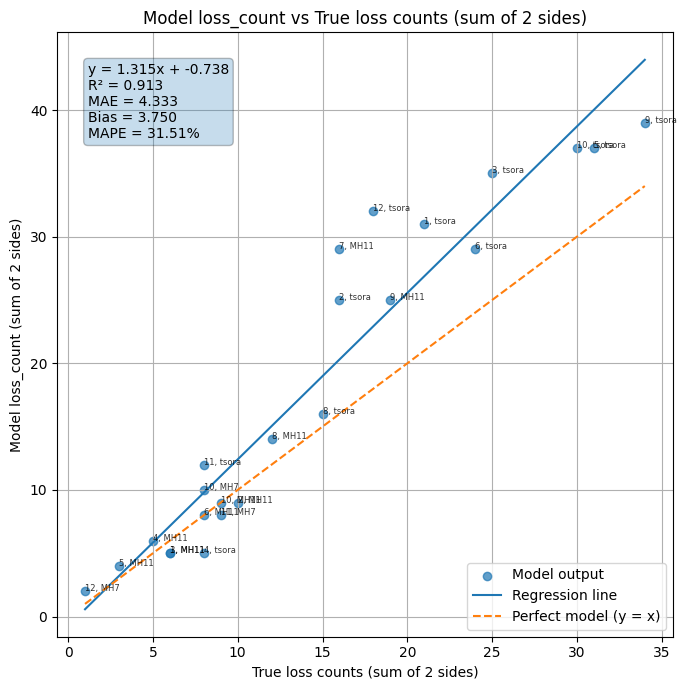

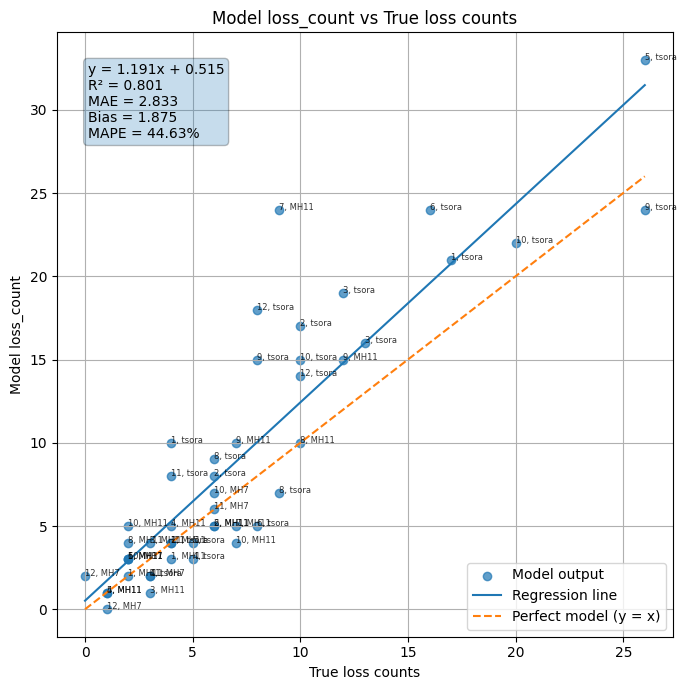

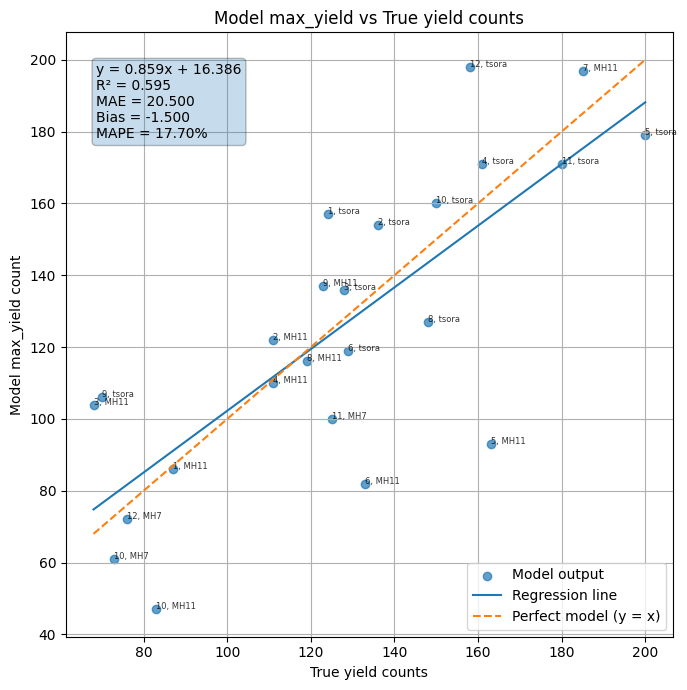

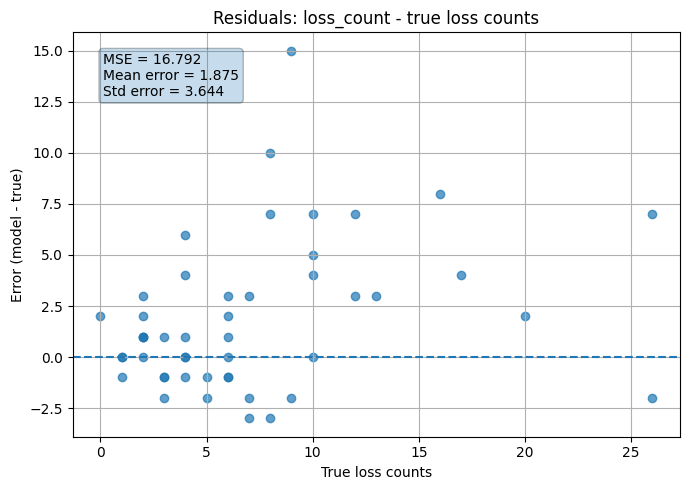

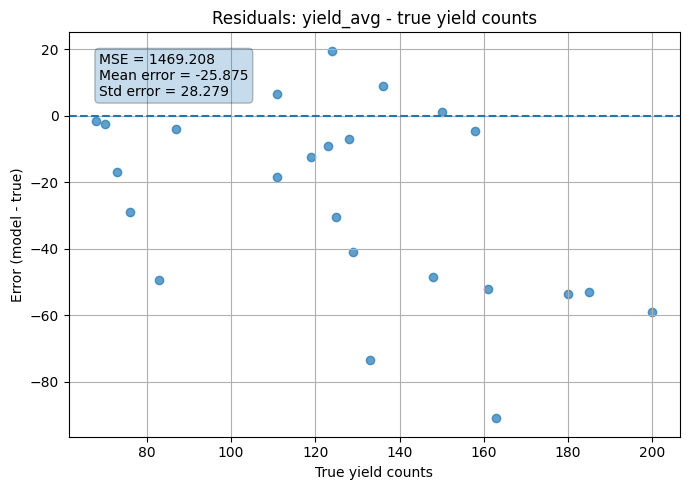

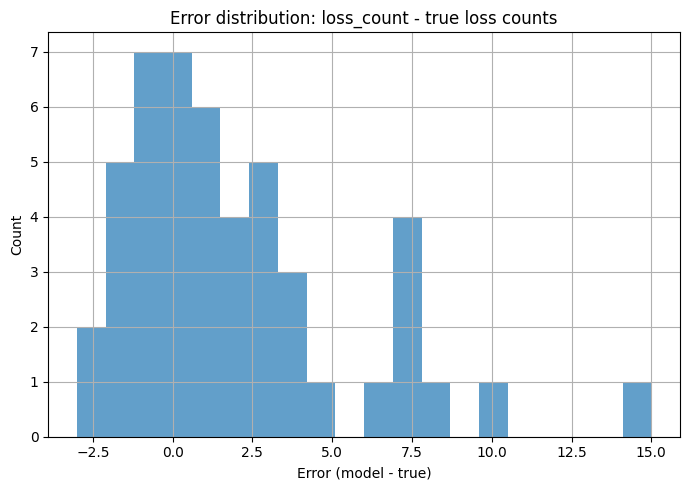

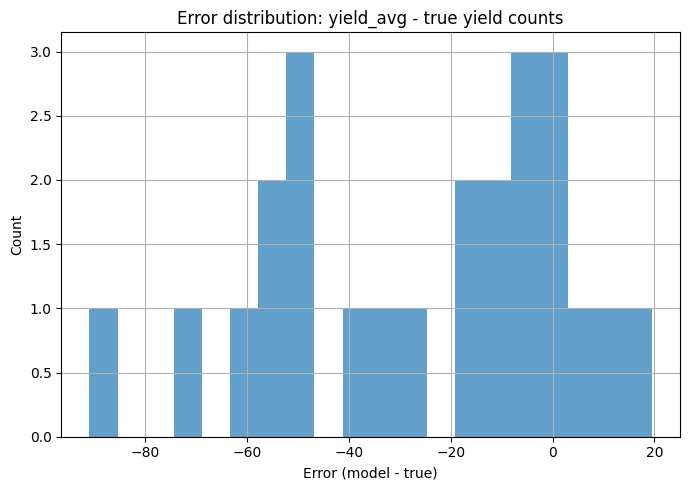

In [ ]:
# 1. loss regression with labels and perfect line
plot_regression(
    x=df["loss_sum_true"],
    y=df["loss_sum_model"],
    labels_df=df,
    x_label="True loss counts (sum of 2 sides)",
    y_label="Model loss_count (sum of 2 sides)",
    title="Model loss_count vs True loss counts (sum of 2 sides)",
)

#loss model aggregated
plot_regression(
    x=df["true loss counts"],
    y=df["loss_count"],
    labels_df=df,
    x_label="True loss counts",
    y_label="Model loss_count",
    title="Model loss_count vs True loss counts",
)


# 2. yield regression by max with labels and perfect line
plot_regression(
    x=df["true yield counts"],
    y=df["max_yield"],
    labels_df=df,
    x_label="True yield counts",
    y_label="Model max_yield count",
    title="Model max_yield vs True yield counts",
)
# 3. residuals for loss
plot_residuals(
    x=df["true loss counts"],
    y=df["loss_count"],
    x_label="True loss counts",
    title="Residuals: loss_count - true loss counts",
)

# 4. residuals for yield
plot_residuals(
    x=df["true yield counts"],
    y=df["yield_avg"],
    x_label="True yield counts",
    title="Residuals: yield_avg - true yield counts",
)

# 5. error histogram for loss
plot_error_hist(
    x=df["true loss counts"],
    y=df["loss_count"],
    title="Error distribution: loss_count - true loss counts",
)

# 6. error histogram for yield
plot_error_hist(
    x=df["true yield counts"],
    y=df["yield_avg"],
    title="Error distribution: yield_avg - true yield counts",
)

